In [50]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Mar 13 12:28:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:01:01.0 Off |                    0 |
| N/A   31C    P0    40W / 250W |  14566MiB / 32510MiB |     10%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  On   | 00000000:01:02.0 Off |                    0 |
| N/A   

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from enum import Enum
import imageio
import hashlib

%matplotlib inline
plt.style.use('seaborn-whitegrid')
%config InlineBackend.figure_format='retina'

dtype = 'float32'
tf.keras.backend.set_floatx(dtype)

In [86]:
################################################################################
# DATASETS
################################################################################


class Dataset:
    def __init__(self, X_train, y_train, X_test, y_test, shape, shape_flattened, vision=True, standardize=True):
        X_train = X_train.astype(dtype)
        y_train = y_train.astype(dtype)
        X_test = X_test.astype(dtype)
        y_test = y_test.astype(dtype)

        if vision:
            X_train = X_train / 255.0
            X_test = X_test / 255.0

        X_train = np.reshape(X_train, shape_flattened)
        X_test = np.reshape(X_test, shape_flattened)

        X = np.concatenate((X_train, X_test), axis=0)
        y = np.concatenate((y_train, y_test), axis=0)

        if standardize:
            from sklearn.preprocessing import StandardScaler

            scaler = StandardScaler()
            scaler.fit(X_train)  # Scaling each feature independently

            X_norm = scaler.transform(X)
            X_train_norm = scaler.transform(X_train)
            X_test_norm = scaler.transform(X_test)
        else:
            X_norm = X.copy()
            X_train_norm = X_train.copy()
            X_test_norm = X_test.copy()

        X_norm = np.reshape(X_norm, shape)
        X_train_norm = np.reshape(X_train_norm, shape)
        X_test_norm = np.reshape(X_test_norm, shape)

        del X, X_train, X_test

        self.X_norm = X_norm
        self.y = y
        self.X_train_norm = X_train_norm
        self.y_train = y_train
        self.X_test_norm = X_test_norm
        self.y_test = y_test


def get_cifar_10_dataset():
    cifar10 = tf.keras.datasets.cifar10
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    shape = (-1, 32, 32, 3)
    shape_flattened = (-1, 3072)  # Scaling each feature independently
    return Dataset(X_train, y_train, X_test, y_test, shape=shape, shape_flattened=shape_flattened)


def get_cifar_100_dataset():
    cifar100 = tf.keras.datasets.cifar100
    (X_train, y_train), (X_test, y_test) = cifar100.load_data()
    shape = (-1, 32, 32, 3)
    shape_flattened = (-1, 3072)  # Scaling each feature independently
    return Dataset(X_train, y_train, X_test, y_test, shape=shape, shape_flattened=shape_flattened)


def get_svhn_dataset():
    from urllib.request import urlretrieve
    from scipy import io

    train_filename, _ = urlretrieve('http://ufldl.stanford.edu/housenumbers/train_32x32.mat')
    test_filename, _ = urlretrieve('http://ufldl.stanford.edu/housenumbers/test_32x32.mat')

    X_train = io.loadmat(train_filename, variable_names='X').get('X')
    y_train = io.loadmat(train_filename, variable_names='y').get('y')
    X_test = io.loadmat(test_filename, variable_names='X').get('X')
    y_test = io.loadmat(test_filename, variable_names='y').get('y')

    X_train = np.moveaxis(X_train, -1, 0)
    y_train -= 1
    X_test = np.moveaxis(X_test, -1, 0)
    y_test -= 1

    shape = (-1, 32, 32, 3)
    shape_flattened = (-1, 3072)  # Scaling each feature independently
    return Dataset(X_train, y_train, X_test, y_test, shape=shape, shape_flattened=shape_flattened)


def get_tiny_imagenet_dataset():
    """
    Original source: https://github.com/sonugiri1043/Train_ResNet_On_Tiny_ImageNet/blob/master/Train_ResNet_On_Tiny_ImageNet.ipynb
    Original author: sonugiri1043@gmail.com
    """

    if not os.path.isdir('IMagenet'):
        ! git clone https://github.com/seshuad/IMagenet

    print("Processing the downloaded dataset...")

    path = 'IMagenet/tiny-imagenet-200/'

    id_dict = {}
    for i, line in enumerate(open(path + 'wnids.txt', 'r')):
        id_dict[line.replace('\n', '')] = i

    train_data = list()
    test_data = list()
    train_labels = list()
    test_labels = list()

    for key, value in id_dict.items():
        train_data += [imageio.imread(path + 'train/{}/images/{}_{}.JPEG'.format(key, key, str(i)), pilmode='RGB') for i in range(500)]
        train_labels_ = np.array([[0]*200]*500)
        train_labels_[:, value] = 1
        train_labels += train_labels_.tolist()

    for line in open(path + 'val/val_annotations.txt'):
        img_name, class_id = line.split('\t')[:2]
        test_data.append(imageio.imread(path + 'val/images/{}'.format(img_name), pilmode='RGB'))
        test_labels_ = np.array([[0]*200])
        test_labels_[0, id_dict[class_id]] = 1
        test_labels += test_labels_.tolist()

    X_train = np.array(train_data)
    y_train = np.argmax(np.array(train_labels), axis=1)
    X_test = np.array(test_data)
    y_test = np.argmax(np.array(test_labels), axis=1)

    shape = (-1, 64, 64, 3)
    shape_flattened = (-1, 12288)  # Scaling each feature independently
    return Dataset(X_train, y_train, X_test, y_test, shape=shape, shape_flattened=shape_flattened)


def get_mnist_dataset():
    mnist = tf.keras.datasets.mnist
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    shape = (-1, 28, 28, 1)
    shape_flattened = (-1, 1)  # Scaling all features together
    return Dataset(X_train, y_train, X_test, y_test, shape=shape, shape_flattened=shape_flattened)


def get_fashion_mnist_dataset():
    fashion_mnist = tf.keras.datasets.fashion_mnist
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    shape = (-1, 28, 28, 1)
    shape_flattened = (-1, 1)  # Scaling all features together
    return Dataset(X_train, y_train, X_test, y_test, shape=shape, shape_flattened=shape_flattened)


def get_fifteen_puzzle_dataset(frac, path=None):
    from sklearn.model_selection import train_test_split

    if path is None:
        from google.colab import drive
        drive.mount('/content/gdrive')
        path = 'gdrive/MyDrive/15-costs-v3.csv'
    costs = pd.read_csv(path)
    costs = costs.sample(frac=frac, random_state=42)

    X_raw = costs.iloc[:,:-1].values
    y = costs['cost'].values
    X = np.apply_along_axis(lambda x: np.eye(16)[x].ravel(), 1, X_raw)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    del X, X_raw, y

    shape = (-1, 256)
    shape_flattened = (-1, 256)  # Scaling all features together
    return Dataset(X_train, y_train, X_test, y_test, shape=shape, shape_flattened=shape_flattened, vision=False)


################################################################################
# REGULARIZERS
################################################################################


class Regularizer(tf.keras.regularizers.Regularizer):
    def __init__(self):
        self.n_new_neurons = 0
        self.scaling_tensor = None
        self.set_regularization_penalty(0.)
        self.set_regularization_method(None)

    def __call__(self, x):
        if self.regularization_method is None or self.regularization_penalty == 0:
            return 0
        elif self.regularization_method == 'weighted_l1':
            return self.weighted_l1(x)
        elif self.regularization_method == 'weighted_l1_reordered':
            return self.weighted_l1_reordered(x)
        elif self.regularization_method == 'group_sparsity':
            return self.group_sparsity(x)
        elif self.regularization_method == 'l1':
            return self.l1(x)
        else:
            raise NotImplementedError(f"Unknown regularization method {self.regularization_method}")
    
    def weighted_l1(self, x):
        # I.e. for a parameter matrix of 4 input and 10 output neurons:
        #
        # [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        #  [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        #  [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        #  [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]
        #
        # the scaling tensor, as well as the resulting weighted values, could be:
        #
        # [[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
        #  [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
        #  [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
        #  [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]]
        #
        # Therefore every additional output neuron is regularized more.

        scaling_tensor = tf.cumsum(tf.constant(self.regularization_penalty, shape=x.shape, dtype=dtype), axis=-1)
        weighted_values = scaling_tensor * tf.abs(x)
        return tf.reduce_sum(weighted_values)
    
    def weighted_l1_reordered(self, x):
        # I.e. for a parameter matrix of 4 input and 10 output neurons:
        #
        # [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        #  [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        #  [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        #  [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]
        #
        # the scaling tensor, as well as the resulting weighted values, could be:
        #
        # [[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
        #  [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
        #  [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
        #  [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]]
        #
        # Therefore every additional output neuron is regularized more.

        if self.update_scaling_tensor:
            scaling_tensor_raw = tf.cumsum(tf.constant(self.regularization_penalty, shape=x.shape, dtype=dtype), axis=-1)

            scaling_tensor_old_neurons = scaling_tensor_raw[:, :-self.n_new_neurons]
            scaling_tensor_new_neurons = scaling_tensor_raw[:, -self.n_new_neurons:]
            scaling_tensor_old_neurons_shuffled = tf.transpose(tf.random.shuffle(tf.transpose(scaling_tensor_old_neurons)))
            self.scaling_tensor = tf.concat([scaling_tensor_old_neurons_shuffled, scaling_tensor_new_neurons], axis=-1)
            self.update_scaling_tensor = False

        weighted_values = self.scaling_tensor * tf.abs(x)
        return tf.reduce_sum(weighted_values)
    
    def group_sparsity(self, x):
        # I.e. for a parameter matrix of 3 input and 5 output neurons:
        #
        # [[1., 1., 1., 1., 1.],
        #  [1., 2., 2., 1., 2.],
        #  [2., 2., 3., 1., 3.]]
        #
        # The resulting vector of group norms is [2., 2., 3., 1., 3.], therefore for
        # every output neuron, its incoming connections form a group.

        group_norms = tf.norm(x, ord=2, axis=0)
        # assert group_norms.shape[0] == x.shape[1]
        return self.regularization_penalty * tf.reduce_sum(group_norms)
    
    def l1(self, x):
        weighted_values = self.regularization_penalty * tf.abs(x)
        return tf.reduce_sum(weighted_values)
    
    def prune(self):
        self.n_new_neurons = 0
        if self.regularization_method == 'weighted_l1_reordered':
            self.update_scaling_tensor = True
    
    def grow(self, n_new_neurons):
        self.n_new_neurons = n_new_neurons
        if self.regularization_method == 'weighted_l1_reordered':
            self.update_scaling_tensor = True
    
    def set_regularization_penalty(self, regularization_penalty):
        self.regularization_penalty = regularization_penalty
    
    def set_regularization_method(self, regularization_method):
        self.regularization_method = regularization_method
        if self.regularization_method == 'weighted_l1_reordered':
            self.update_scaling_tensor = True
        else:
            self.update_scaling_tensor = None

    def get_config(self):
        return {'regularization_penalty': float(self.regularization_penalty)}


################################################################################
# LAYERS
################################################################################


class DASLayer(tf.keras.layers.Layer):
    def __init__(self, input_shape):
        super().__init__()

        self.inpt_shp = input_shape


class Dense(DASLayer):
    def __init__(self, units, activation, kernel_initializer='glorot_uniform', 
                 bias_initializer='zeros', input_shape=None, fixed_size=False):
        super().__init__(input_shape)

        self.units = units
        self.activation = activation
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.fixed_size = fixed_size
        
        self.A = tf.keras.activations.get(activation)
        self.W_init = tf.keras.initializers.get(kernel_initializer)
        self.b_init = tf.keras.initializers.get(bias_initializer)
        self.regularizer = Regularizer()
    
    def build(self, input_shape):
        input_units = input_shape[-1]

        self.W = tf.Variable(
            name='W',
            initial_value=self.W_init(shape=(input_units, self.units), dtype=dtype),
            trainable=True)
        
        self.b = tf.Variable(
            name='b',
            initial_value=self.b_init(shape=(self.units,), dtype=dtype),
            trainable=True)
        
        self.add_loss(lambda: self.regularizer(tf.concat([self.W, tf.reshape(self.b, (1, -1))], axis=0)))
    
    def call(self, inputs, training=None):
        return self.A(tf.matmul(inputs, self.W) + self.b)

    def get_size(self):
        return self.W.shape[0], self.W.shape[1]
    
    def prune(self, threshold, active_input_units_indices):
        # Remove connections from pruned units in previous layer
        new_W = tf.gather(self.W.value(), active_input_units_indices, axis=0)

        if self.fixed_size:
            active_output_neurons_indices = list(range(new_W.shape[1]))
        else:
            # Prune units in this layer
            weights_with_biases = tf.concat([new_W, tf.reshape(self.b.value(), (1, -1))], axis=0)
            neurons_are_active = tf.math.reduce_max(tf.abs(weights_with_biases), axis=0) >= threshold
            active_output_neurons_indices = tf.reshape(tf.where(neurons_are_active), (-1,))
            
            new_W = tf.gather(new_W, active_output_neurons_indices, axis=1)
            new_b = tf.gather(self.b.value(), active_output_neurons_indices, axis=0)

            self.b = tf.Variable(name='b', initial_value=new_b, trainable=True)

        self.W = tf.Variable(name='W', initial_value=new_W, trainable=True)

        self.regularizer.prune()
        return active_output_neurons_indices
    
    def grow(self, n_new_input_units, percentage, min_new_units, scaling_factor):
        if n_new_input_units > 0:
            # Add connections to grown units in previous layer
            W_growth = self.W_init(shape=(self.W.shape[0] + n_new_input_units, self.W.shape[1]), dtype=dtype)[-n_new_input_units:, :] * scaling_factor  # TODO is it better to be multiplying here by scaling_factor? It does help with not increasing the max weights of existing neurons when new neurons are added.
            new_W = tf.concat([self.W.value(), W_growth], axis=0)
        else:
            new_W = self.W.value()

        if self.fixed_size:
            n_new_output_units = 0
        else:
            # Grow new units in this layer
            n_new_output_units = max(min_new_units, int(new_W.shape[1] * percentage))
            if n_new_output_units > 0:
                W_growth = self.W_init(shape=(new_W.shape[0], new_W.shape[1] + n_new_output_units), dtype=dtype)[:, -n_new_output_units:] * scaling_factor
                b_growth = self.b_init(shape=(n_new_output_units,), dtype=dtype)  # TODO for all possible bias initializers to work properly, the whole bias vector should be initialized at once
                new_W = tf.concat([new_W, W_growth], axis=1)
                new_b = tf.concat([self.b.value(), b_growth], axis=0)

                self.b = tf.Variable(name='b', initial_value=new_b, trainable=True)

        self.W = tf.Variable(name='W', initial_value=new_W, trainable=True)

        self.regularizer.grow(n_new_output_units)
        return n_new_output_units
    
    def mutate(self, mutation_strength):
        self.W.assign_add(tf.random.normal(self.W.shape, mean=0.0, stddev=mutation_strength))
        self.b.assign_add(tf.random.normal(self.b.shape, mean=0.0, stddev=mutation_strength))
    
    def set_regularization_penalty(self, regularization_penalty):
        if not self.fixed_size:
            self.regularizer.set_regularization_penalty(regularization_penalty)
    
    def set_regularization_method(self, regularization_method):
        if not self.fixed_size:
            self.regularizer.set_regularization_method(regularization_method)
    
    def get_param_string():
        param_string = ""
        weights_with_bias = tf.concat([self.W, tf.reshape(self.b, (1, -1))], axis=0)
        max_parameters = tf.math.reduce_max(tf.abs(weights_with_bias), axis=0).numpy()
        magnitudes = np.floor(np.log10(max_parameters))
        for m in magnitudes:
            if m > 0:
                m = 0
            param_string += str(int(-m))
        return param_string


class Conv2D(DASLayer):
    def __init__(self, filters, filter_size, activation, strides=(1, 1), 
                 padding='SAME', kernel_initializer='glorot_uniform',
                 bias_initializer='zeros', input_shape=None, fixed_size=False):
        super().__init__(input_shape)
    
        self.filters = filters
        self.filter_size = filter_size
        self.activation = activation
        self.strides = strides
        self.padding = padding
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.fixed_size = fixed_size
        
        self.A = tf.keras.activations.get(activation)
        self.F_init = tf.keras.initializers.get(kernel_initializer)
        self.b_init = tf.keras.initializers.get(bias_initializer)
        self.regularizer = Regularizer()
    
    def build(self, input_shape):
        input_filters = input_shape[-1]

        self.F = tf.Variable(
            name='F',
            initial_value=self.F_init(
                shape=(self.filter_size[0], self.filter_size[1], input_filters, self.filters), dtype=dtype
            ),
            trainable=True)
        
        self.b = tf.Variable(
            name='b',
            initial_value=self.b_init(shape=(self.filters,), dtype=dtype),
            trainable=True)

        self.add_loss(lambda: self.regularizer(tf.concat([tf.reshape(self.F, (-1, self.F.shape[-1])), tf.reshape(self.b, (1, -1))], axis=0)))
    
    def call(self, inputs, training=None):
        y = tf.nn.conv2d(inputs, self.F, strides=self.strides, padding=self.padding)
        y = tf.nn.bias_add(y, self.b)
        y = self.A(y)
        return y
    
    def get_size(self):
        return self.F.shape[-2], self.F.shape[-1]
    
    def prune(self, threshold, active_input_units_indices):
        # Remove connections from pruned units in previous layer
        new_F = tf.gather(self.F.value(), active_input_units_indices, axis=-2)

        if self.fixed_size:
            active_output_filters_indices = list(range(new_F.shape[-1]))
        else:
            # Prune units in this layer
            F_reduced_max = tf.reshape(tf.math.reduce_max(tf.abs(new_F), axis=(0, 1, 2)), (1, -1))
            F_reduced_max_with_biases = tf.concat([F_reduced_max, tf.reshape(self.b.value(), (1, -1))], axis=0)
            filters_are_active = tf.math.reduce_max(tf.abs(F_reduced_max_with_biases), axis=0) >= threshold
            active_output_filters_indices = tf.reshape(tf.where(filters_are_active), (-1,))
            
            new_F = tf.gather(new_F, active_output_filters_indices, axis=-1)
            new_b = tf.gather(self.b.value(), active_output_filters_indices, axis=0)

            self.b = tf.Variable(name='b', initial_value=new_b, trainable=True)

        self.F = tf.Variable(name='F', initial_value=new_F, trainable=True)

        self.regularizer.prune()
        return active_output_filters_indices

    def grow(self, n_new_input_units, percentage, min_new_units, scaling_factor):
        if n_new_input_units > 0:
            # Add connections to grown units in previous layer
            F_growth = self.F_init(shape=(self.F.shape[0], self.F.shape[1], self.F.shape[2] + n_new_input_units, self.F.shape[3]), dtype=dtype)[:, :, -n_new_input_units:, :] * scaling_factor  # TODO is it better to be multiplying here by scaling_factor? It does help with not increasing the max weights of existing neurons when new neurons are added.
            new_F = tf.concat([self.F.value(), F_growth], axis=-2)
        else:
            new_F = self.F.value()

        if self.fixed_size:
            n_new_output_units = 0
        else:
            # Grow new units in this layer
            n_new_output_units = max(min_new_units, int(new_F.shape[-1] * percentage))
            if n_new_output_units > 0:
                F_growth = self.F_init(shape=(new_F.shape[0], new_F.shape[1], new_F.shape[2], new_F.shape[3] + n_new_output_units), dtype=dtype)[:, :, :, -n_new_output_units:] * scaling_factor
                b_growth = self.b_init(shape=(n_new_output_units,), dtype=dtype)  # TODO for all possible bias initializers to work properly, the whole bias vector should be initialized at once
                new_F = tf.concat([new_F, F_growth], axis=-1)
                new_b = tf.concat([self.b.value(), b_growth], axis=0)

                self.b = tf.Variable(name='b', initial_value=new_b, trainable=True)

        self.F = tf.Variable(name='F', initial_value=new_F, trainable=True)

        self.regularizer.grow(n_new_output_units)
        return n_new_output_units
    
    def mutate(self, mutation_strength):
        self.F.assign_add(tf.random.normal(self.F.shape, mean=0.0, stddev=mutation_strength))
        self.b.assign_add(tf.random.normal(self.b.shape, mean=0.0, stddev=mutation_strength))
    
    def set_regularization_penalty(self, regularization_penalty):
        if not self.fixed_size:
            self.regularizer.set_regularization_penalty(regularization_penalty)
    
    def set_regularization_method(self, regularization_method):
        if not self.fixed_size:
            self.regularizer.set_regularization_method(regularization_method)

    def get_param_string():
        param_string = ""
        # TODO
        return param_string


class Flatten(tf.keras.Model):
    def call(self, inputs, training=None):
        return tf.reshape(tf.transpose(inputs, perm=[0, 3, 1, 2]), (inputs.shape[0], -1))


################################################################################
# MODELS
################################################################################


class Epoch:
    def __init__(self, grow, prune, regularization_penalty, regularization_method):
        self.grow = grow
        self.prune = prune
        self.regularization_penalty = regularization_penalty
        self.regularization_method = regularization_method
    
    def __str__(self):
        return f'{int(self.grow)}{int(self.prune)}{self.regularization_penalty}{self.regularization_method}'
    
    def __repr__(self):
        return self.__str__()


class DynamicEpoch(Epoch):
    def __init__(self, regularization_penalty, regularization_method):
        super().__init__(True, True, regularization_penalty, regularization_method)


class StaticEpoch(Epoch):
    def __init__(self, regularization_penalty, regularization_method):
        super().__init__(False, False, regularization_penalty, regularization_method)


class StaticEpochNoRegularization(StaticEpoch):
    def __init__(self):
        super().__init__(0., None)


class Schedule:
    def __init__(self, epochs):
        self.epochs = epochs

    def __iter__(self):
        return self.epochs.__iter__()
    
    def __len__(self):
        return len(self.epochs)
    
    def __str__(self):
        text = ''.join([str(epoch) for epoch in self.epochs])
        return hashlib.sha1(text.encode('utf-8')).hexdigest()[:10]
    
    def __repr__(self):
        return self.__str__()


class Sequential(tf.keras.Model):
    def __init__(self, layers, activation=None):
        super().__init__()
        
        self.lrs = layers
        
    def call(self, inputs, training=None):
        x = inputs
        for layer in self.lrs:
            x = layer(x, training=training)
        return x
    
    def get_layer_input_shape(self, target_layer):
        if target_layer.inpt_shp is not None:
            return target_layer.inpt_shp

        input = np.random.normal(size=(1,) + self.lrs[0].inpt_shp)
        for layer in self.lrs:
            if layer is target_layer:
                return tuple(input.shape[1:])
            input = layer(input)
        raise Exception("Layer not found in the model.")

    def get_layer_output_shape(self, target_layer):
        input = np.random.normal(size=(1,) + self.lrs[0].inpt_shp)
        for layer in self.lrs:
            output = layer(input)
            if layer is target_layer:
                return tuple(output.shape[1:])
            input = output
        raise Exception("Layer not found in the model.")
    
    def get_layer_sizes(self):
        """
        Returns the sizes of all layers in the model, including the input and output layer.
        """
        layer_sizes = list()
        first_layer = True
        for l in range(len(self.lrs)):
            layer = self.lrs[l]
            if isinstance(layer, DASLayer):
                layer_size = layer.get_size()
                if first_layer:
                    layer_sizes.append(layer_size[0])
                    first_layer = False
                layer_sizes.append(layer_size[1])
        return layer_sizes
    
    def get_hidden_layer_sizes(self):
        return self.get_layer_sizes()[1:-1]
    
    def get_regularization_penalty(self):
        #TODO improve
        return self.lrs[-2].regularizer.regularization_penalty
    
    def set_regularization_penalty(self, regularization_penalty):
        for layer in self.lrs:
            if isinstance(layer, DASLayer) and not layer.fixed_size:
                layer.set_regularization_penalty(regularization_penalty)
    
    def set_regularization_method(self, regularization_method):
        for layer in self.lrs:
            if isinstance(layer, DASLayer) and not layer.fixed_size:
                layer.set_regularization_method(regularization_method)

    def prune(self, params):
        input_shape = self.get_layer_input_shape(self.lrs[0])
        n_input_units = input_shape[-1]
        active_units_indices = list(range(n_input_units))

        last_custom_layer = None
        for layer in self.lrs:
            if isinstance(layer, DASLayer):
                if last_custom_layer is not None and type(last_custom_layer) != type(layer):
                    if type(last_custom_layer) == Conv2D and type(layer) == Dense:
                        convolutional_shape = self.get_layer_output_shape(last_custom_layer)
                        active_units_indices = self.convert_channel_indices_to_flattened_indices(active_units_indices, convolutional_shape)
                    else:
                        raise Exception("Incorrect order of custom layer types.")
                active_units_indices = layer.prune(params.pruning_threshold, active_units_indices)
                last_custom_layer = layer
    
    def grow(self, params):   
        n_new_units = 0

        last_custom_layer = None
        for layer in self.lrs:
            if isinstance(layer, DASLayer):
                if last_custom_layer is not None and type(last_custom_layer) != type(layer):
                    if type(last_custom_layer) == Conv2D and type(layer) == Dense:
                        convolutional_shape = self.get_layer_output_shape(last_custom_layer)
                        n_new_units = n_new_units * convolutional_shape[0] * convolutional_shape[1]
                    else:
                        raise Exception("Incorrect order of custom layer types.")
                n_new_units = layer.grow(n_new_units, params.growth_percentage, min_new_units=params.min_new_neurons, scaling_factor=params.pruning_threshold)
                last_custom_layer = layer
    
    def mutate(self, mutation_strength):
        for layer in self.lrs:
            if isinstance(layer, DASLayer):
                layer.mutate(mutation_strength)
    
    @staticmethod
    def convert_channel_indices_to_flattened_indices(channel_indices, convolutional_shape):
        dense_indices = list()
        units_per_channel = convolutional_shape[0] * convolutional_shape[1]
        for channel_index in channel_indices:
            for iter in range(units_per_channel):
                dense_indices.append(channel_index * units_per_channel + iter)
        return dense_indices
    
    def print_neurons(self):
        for layer in self.lrs[:-1]:
            print(layer.get_param_string())
    
    def evaluate(self, params, summed_training_loss, summed_training_metric):
        # Calculate training loss and metric
        if summed_training_loss is not None:
            loss = summed_training_loss / params.x.shape[0]
        else:
            loss = None
        
        if summed_training_metric is not None:
            metric = summed_training_metric / params.x.shape[0]
        else:
            metric = None
        
        # Calculate val loss and metric
        summed_val_loss = 0
        summed_val_metric = 0
        n_val_instances = 0
        
        for step, (x_batch, y_batch) in enumerate(params.val_dataset):
            # y_pred = tf.reshape(self(x_batch, training=False), y_batch.shape)
            y_pred = self(x_batch, training=False)
            summed_val_loss += tf.reduce_sum(params.loss_fn(y_batch, y_pred))
            summed_val_metric += float(tf.reduce_sum(params.metric_fn(y_batch, y_pred)))
            n_val_instances += x_batch.shape[0]
        
        val_loss = summed_val_loss / n_val_instances
        val_metric = summed_val_metric / n_val_instances

        return loss, metric, val_loss, val_metric

    def list_params(self):
        trainable_count = np.sum([K.count_params(w) for w in self.trainable_weights])
        non_trainable_count = np.sum([K.count_params(w) for w in self.non_trainable_weights])
        total_count = trainable_count + non_trainable_count

        print('Total params: {:,}'.format(total_count))
        print('Trainable params: {:,}'.format(trainable_count))
        print('Non-trainable params: {:,}'.format(non_trainable_count))

        return total_count, trainable_count, non_trainable_count
    
    def print_epoch_statistics(self, params, summed_training_loss, summed_training_metric, message=None, require_result=False):
        if not params.verbose:
            if require_result:
                return self.evaluate(params, summed_training_loss, summed_training_metric)
            else:
                return
        
        loss, metric, val_loss, val_metric = self.evaluate(params, summed_training_loss, summed_training_metric)  

        if message is not None:
            print(message)
        
        print(f"loss: {loss} - metric: {metric} - val_loss: {val_loss} - val_metric: {val_metric} - penalty: {self.get_regularization_penalty()}")
        hidden_layer_sizes = self.get_hidden_layer_sizes()
        print(f"hidden layer sizes: {hidden_layer_sizes}, total units: {sum(hidden_layer_sizes)}")
        if params.print_neurons:
            self.print_neurons()
        
        if require_result:
            return loss, metric, val_loss, val_metric
    
    def update_history(self, params, loss, metric, val_loss, val_metric):
        params.history['loss'].append(float(loss))
        params.history['metric'].append(float(metric))
        params.history['val_loss'].append(float(val_loss))
        params.history['val_metric'].append(float(val_metric))
        params.history['hidden_layer_sizes'].append(self.get_hidden_layer_sizes())
    
    @staticmethod
    def prepare_datasets(x, y, batch_size, validation_data):
        train_dataset = tf.data.Dataset.from_tensor_slices((x, y))
        train_dataset = train_dataset.shuffle(buffer_size=20000).batch(batch_size)
        val_dataset = tf.data.Dataset.from_tensor_slices(validation_data).batch(batch_size)
        return train_dataset.prefetch(tf.data.AUTOTUNE), val_dataset.prefetch(tf.data.AUTOTUNE)
    
    def manage_dynamic_regularization(self, params, val_loss):
        if val_loss >= params.best_conditional_val_loss * params.stall_coefficient:
            # Training is currently in stall
            if not params.training_stalled:
                penalty = self.get_regularization_penalty() * params.regularization_penalty_multiplier
                print("Changing penalty...")
                # TODO this must be modified, penalty can differ for each layer
                self.set_regularization_penalty(penalty)
                params.training_stalled = True
        else:
            params.best_conditional_val_loss = val_loss
            params.training_stalled = False
    
    def grow_wrapper(self, params):
        dynamic_reqularization_active = params.regularization_penalty_multiplier != 1.
        if dynamic_reqularization_active:
            loss, metric, val_loss, val_metric = self.print_epoch_statistics(params, None, None, "Before growing:", require_result=True)
            self.manage_dynamic_regularization(params, val_loss)
        else:
            self.print_epoch_statistics(params, None, None, "Before growing:")

        self.grow(params)
        self.print_epoch_statistics(params, None, None, "After growing:")
    
    def prune_wrapper(self, params, summed_loss, summed_metric):
        loss, metric, _, _ = self.print_epoch_statistics(params, summed_loss, summed_metric, "Before pruning:", require_result=True)
        self.prune(params)
        _, _, val_loss, val_metric = self.print_epoch_statistics(params, None, None, "After pruning:", require_result=True)

        self.update_history(params, loss, metric, val_loss, val_metric)
    
    class ParameterContainer:
        def __init__(self, x, y, optimizer, batch_size, min_new_neurons, validation_data, pruning_threshold, regularization_penalty_multiplier, 
                     stall_coefficient, growth_percentage, mini_epochs_per_epoch, verbose, print_neurons, use_static_graph, loss_fn, metric_fn):
            self.x = x
            self.y = y
            self.optimizer = optimizer
            self.batch_size = batch_size
            self.min_new_neurons = min_new_neurons
            self.validation_data = validation_data
            self.pruning_threshold = pruning_threshold
            self.regularization_penalty_multiplier = regularization_penalty_multiplier
            self.stall_coefficient = stall_coefficient
            self.growth_percentage = growth_percentage
            self.mini_epochs_per_epoch = mini_epochs_per_epoch
            self.verbose = verbose
            self.print_neurons = print_neurons
            self.use_static_graph = use_static_graph
            self.loss_fn = loss_fn
            self.metric_fn = metric_fn

            self.train_dataset, self.val_dataset = Sequential.prepare_datasets(x, y, batch_size, validation_data)
            self.history = self.prepare_history()

            self.best_conditional_val_loss = np.inf
            self.training_stalled = False
        
        @staticmethod
        def prepare_history():
            history = {
                'loss': list(),
                'metric': list(),
                'val_loss': list(),
                'val_metric': list(),
                'hidden_layer_sizes': list(),
            }
            return history
    
    def fit_single_step(self, params, x_batch, y_batch):
        with tf.GradientTape() as tape:
            # y_pred = tf.reshape(self(x_batch, training=True), y_batch.shape)
            y_pred = self(x_batch, training=True)
            raw_loss = params.loss_fn(y_batch, y_pred)
            loss_value = tf.reduce_mean(raw_loss)
            loss_value += sum(self.losses)  # Add losses registered by model.add_loss

            loss = tf.reduce_sum(raw_loss)
            metric = float(tf.reduce_sum(params.metric_fn(y_batch, y_pred)))

        grads = tape.gradient(loss_value, self.trainable_variables)
        params.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        return loss, metric
    
    def fit_single_epoch(self, params):
        summed_loss = 0
        summed_metric = 0
        
        for mini_epoch in range(params.mini_epochs_per_epoch):
            summed_loss = 0
            summed_metric = 0

            if params.use_static_graph:
                fit_single_step_function = tf.function(self.fit_single_step)
            else:
                fit_single_step_function = self.fit_single_step
            for step, (x_batch, y_batch) in enumerate(params.train_dataset):
                loss, metric = fit_single_step_function(params, x_batch, y_batch)
                summed_loss += loss
                summed_metric += metric
        
        return summed_loss, summed_metric

    def fit(self, x, y, optimizer, schedule, batch_size, min_new_neurons, validation_data, pruning_threshold=0.001, regularization_penalty_multiplier=1., 
            stall_coefficient=1, growth_percentage=0.2, mini_epochs_per_epoch=1, verbose=True, print_neurons=False, use_static_graph=True, 
            loss_fn=tf.keras.losses.sparse_categorical_crossentropy, metric_fn=tf.keras.metrics.sparse_categorical_accuracy):
        params = self.ParameterContainer(x=x, y=y, optimizer=optimizer, batch_size=batch_size, min_new_neurons=min_new_neurons, validation_data=validation_data, 
                                         pruning_threshold=pruning_threshold, regularization_penalty_multiplier=regularization_penalty_multiplier, stall_coefficient=stall_coefficient, 
                                         growth_percentage=growth_percentage, mini_epochs_per_epoch=mini_epochs_per_epoch, verbose=verbose, print_neurons=print_neurons, 
                                         use_static_graph=use_static_graph, loss_fn=loss_fn, metric_fn=metric_fn)
        self.build(x.shape)  # Necessary when verbose == False

        for epoch_no, epoch in enumerate(schedule):
            if verbose:
                print("##########################################################")
                print(f"Epoch {epoch_no + 1}/{len(schedule)}")
            
            self.set_regularization_penalty(epoch.regularization_penalty)
            self.set_regularization_method(epoch.regularization_method)

            if epoch.grow:
                self.grow_wrapper(params)
            
            summed_loss, summed_metric = self.fit_single_epoch(params)

            if epoch.prune:
                self.prune_wrapper(params, summed_loss, summed_metric)
            else:
                loss, metric, val_loss, val_metric = self.print_epoch_statistics(params, summed_loss, summed_metric, require_result=True)
                self.update_history(params, loss, metric, val_loss, val_metric)
        
        return params.history


################################################################################
# HELPER FUNCTIONS
################################################################################


def get_statistics_from_history(history):
    best_epoch_number = np.argmin(history['val_loss'])
    best_val_loss = history['val_loss'][best_epoch_number]
    best_val_metric = history['val_metric'][best_epoch_number]
    best_hidden_layer_sizes = history['hidden_layer_sizes'][best_epoch_number]
    return best_val_loss, best_val_metric, best_hidden_layer_sizes


def get_statistics_from_histories(histories):
    best_val_losses = list()
    best_val_metrics = list()
    all_best_hidden_layer_sizes = list()

    for history in histories:
        best_val_loss, best_val_metric, best_hidden_layer_sizes = get_statistics_from_history(history)
        best_val_losses.append(best_val_loss)
        best_val_metrics.append(best_val_metric)
        all_best_hidden_layer_sizes.append(best_hidden_layer_sizes)
    
    mean_best_val_loss = np.mean(best_val_losses)
    mean_best_val_metric = np.mean(best_val_metrics)
    mean_best_hidden_layer_sizes = [np.mean(layer) for layer in list(zip(*all_best_hidden_layer_sizes))]
    
    return mean_best_val_loss, mean_best_val_metric, mean_best_hidden_layer_sizes


def cross_validate(train_fn, x, y, n_splits, random_state=42, *args, **kwargs):
    from sklearn.model_selection import KFold

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    histories = list()
    for i, (train_index, test_index) in enumerate(kf.split(x)):
        xtrain, xtest = x[train_index], x[test_index]
        ytrain, ytest = y[train_index], y[test_index]

        history = train_fn(xtrain, ytrain, validation_data=(xtest, ytest), *args, **kwargs)
        histories.append(history)

        best_val_loss, best_val_metric, best_hidden_layer_sizes = get_statistics_from_history(history)
        print(f"Run {i} completed, best_val_loss: {best_val_loss}, best_val_metric: {best_val_metric}, best_hidden_layer_sizes: {best_hidden_layer_sizes}")

    mean_best_val_loss, mean_best_val_metric, mean_best_hidden_layer_sizes = get_statistics_from_histories(histories)
    print(f'mean_best_val_loss: {mean_best_val_loss}')
    print(f'mean_best_val_metric: {mean_best_val_metric}')
    print(f'mean_best_hidden_layer_sizes: {mean_best_hidden_layer_sizes}')

    return histories, mean_best_hidden_layer_sizes


def hyperparameter_search(train_fn, x, y, validation_data, *args, **kwargs):
    from itertools import product

    all_params = [*args] + list(kwargs.values())
    histories = list()

    best_overall_val_loss = np.inf
    best_overall_val_metric = None
    best_overall_combination = None

    for combination in product(*all_params):
        combination_args = combination[:len(args)]

        combination_kwargs_values = combination[len(args):]
        combination_kwargs = dict(zip(kwargs.keys(), combination_kwargs_values))

        history = train_fn(x, y, validation_data, *combination_args, **combination_kwargs)
        history['parameters'] = combination
        histories.append(history)

        best_val_loss, best_val_metric, best_hidden_layer_sizes = get_statistics_from_history(history)
        print(f"Run with parameters {combination} completed, best_val_loss: {best_val_loss}, best_val_metric: {best_val_metric}, best_hidden_layer_sizes: {best_hidden_layer_sizes}")

        if best_val_loss < best_overall_val_loss:
            best_overall_val_loss = best_val_loss
            best_overall_val_metric = best_val_metric
            best_overall_combination = combination
    
    print(f'Best overall combination: {best_overall_combination}, val_metric: {best_overall_val_metric}')

    return histories, best_overall_combination


def get_convolutional_model(x, layer_sizes, output_neurons=10):
    model = Sequential([
        Conv2D(layer_sizes[0], filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', kernel_initializer='lecun_normal', input_shape=x[0,:,:,:].shape),
        Conv2D(layer_sizes[1], filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.2),
        Conv2D(layer_sizes[2], filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', kernel_initializer='lecun_normal'),
        Conv2D(layer_sizes[3], filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.5),
        Flatten(),
        Dense(layer_sizes[4], activation='selu', kernel_initializer='lecun_normal'),
        Dense(output_neurons, activation='softmax', fixed_size=True),
    ])
    return model


def get_dense_model(x, layer_sizes):
    layers = list()
    
    layers.append(Dense(layer_sizes[0], activation='selu', kernel_initializer='lecun_normal', input_shape=x[0, :].shape))
    for layer_size in layer_sizes[1:]:
        layers.append(Dense(layer_size, activation='selu', kernel_initializer='lecun_normal'))
    layers.append(Dense(1, activation=None, kernel_initializer='lecun_normal', fixed_size=True))
    
    model = Sequential(layers)
    return model


def train_fn_conv(x, y, validation_data, learning_rate, schedule, layer_sizes, output_neurons=10, min_new_neurons=20, 
             growth_percentage=0.2, verbose=False, use_static_graph=True):
    batch_size = 128

    model = get_convolutional_model(x, layer_sizes, output_neurons)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    history = model.fit(x=x, y=y, optimizer=optimizer, schedule=schedule, batch_size=batch_size, min_new_neurons=min_new_neurons, 
                        validation_data=validation_data, growth_percentage=growth_percentage, verbose=verbose, use_static_graph=use_static_graph)
    
    return history


def squared_error(y_true, y_pred):
    return (y_true - y_pred) ** 2


def train_fn_dense(x, y, validation_data, learning_rate, schedule, layer_sizes, min_new_neurons=20, 
             growth_percentage=0.2, verbose=False, use_static_graph=True):
    batch_size = 128

    model = get_dense_model(x, layer_sizes)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    history = model.fit(x=x, y=y, optimizer=optimizer, schedule=schedule, batch_size=batch_size, min_new_neurons=min_new_neurons, 
                        validation_data=validation_data, growth_percentage=growth_percentage, verbose=verbose, use_static_graph=use_static_graph,
                        loss_fn=squared_error, metric_fn=squared_error)
    
    return history

# Evolution

In [105]:
class Individual:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.history = Sequential.ParameterContainer.prepare_history()


def initialize_population(population_size, x, layer_sizes, output_neurons, learning_rate):
    population = list()
    for _ in range(population_size):
        model = get_convolutional_model(x, layer_sizes, output_neurons=output_neurons)
        model.build(x.shape)
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        individual = Individual(model, optimizer)
        population.append(individual)
    return population


def get_fitness(individual):
    return individual.history['val_loss'][-1]


def get_best_individual(population):
    best_individual = None
    best_fitness = - np.inf
    for individual in population:
        fitness = get_fitness(individual)
        if fitness > best_fitness:
            best_individual = individual
            best_fitness = fitness
    return best_individual


def mutation(population, mutation_strength):
    for individual in population:
        model = individual.model
        model.mutate(mutation_strength)
    return population


def extend_history(old_history, new_history):
    for key in old_history.keys():
        old_history[key].extend(new_history[key])


def training(population, x, y, validation_data, batch_size, min_new_neurons, growth_percentage, verbose, use_static_graph):
    for individual in population:
        model = individual.model
        optimizer = individual.optimizer
        schedule = Schedule([StaticEpochNoRegularization()])
        history = model.fit(x=x, y=y, optimizer=optimizer, schedule=schedule, batch_size=batch_size, min_new_neurons=min_new_neurons, 
                            validation_data=validation_data, growth_percentage=growth_percentage, verbose=verbose, use_static_graph=use_static_graph)
        extend_history(individual.history, history)
    return population


def tournament_selection(population, population_size, tournament_size):
    new_population = list()

    while len(new_population) < population_size:
        selection = np.random.choice(list(range(len(population))), size=tournament_size, replace=False)
        best_individual = None
        best_fitness = - np.inf
        for individual_index in selection:
            individual = population[individual_index]
            fitness = get_fitness(individual)
            if fitness > best_fitness:
                best_individual = individual
                best_fitness = fitness
        new_population.append(best_individual)

    return new_population


def measure_fitnesses(population):
    fitnesses = list()
    for individual in population:
        fitnesses.append(get_fitness(individual))
    return fitnesses


def evolution(x, y, validation_data, batch_size, layer_sizes, output_neurons, learning_rate, mutation_strength, population_size=10, n_generations=10, 
              tournament_size=3, elitism=True, min_new_neurons=20, growth_percentage=0.2):
    population = initialize_population(population_size, x, layer_sizes, output_neurons, learning_rate)
    fitnesses_history = list()
    for generation in range(n_generations):
        if generation > 0:
            best_individual = get_best_individual(population)
            population = mutation(population, mutation_strength)
        population = training(population, x, y, validation_data, batch_size, min_new_neurons, 
                              growth_percentage, verbose=False, use_static_graph=True)
        population = tournament_selection(population, population_size, tournament_size)
        if elitism and generation > 0:
                population.append(best_individual)
        fitnesses = measure_fitnesses(population)
        print(fitnesses)
        fitnesses_history.append(fitnesses)

    best_individual = get_best_individual(population)
    fitness = get_fitness(best_individual)
    
    return fitness, fitnesses_history

In [31]:
fashion_mnist = get_fashion_mnist_dataset()

In [106]:
evolution(x=fashion_mnist.X_train_norm, y=fashion_mnist.y_train, validation_data=(fashion_mnist.X_test_norm, fashion_mnist.y_test),
          batch_size=32, layer_sizes=[50, 50, 50, 50, 50], output_neurons=10, learning_rate=0.0004, mutation_strength=0.01, population_size=3)

KeyboardInterrupt: 

In [ ]:
%%time

# schedule = Schedule([DynamicEpoch(0.00002, 'weighted_l1')] * 2)
schedule = Schedule([StaticEpoch(0, None)] * 2)
train_fn_conv(x=fashion_mnist.X_train_norm, y=fashion_mnist.y_train, validation_data=(fashion_mnist.X_test_norm, fashion_mnist.y_test), 
              learning_rate=0.0004, schedule=schedule, layer_sizes=[100, 100, 100, 100, 100], output_neurons=10, min_new_neurons=20, 
              growth_percentage=0.2, verbose=True, use_static_graph=True)

# Backup/legacy code

In [6]:
fifteen_puzzle = get_fifteen_puzzle_dataset(frac=0.1, path='../../datasets/15-costs-v3.csv')

## Initial experiments

In [ ]:
%%time

schedule = Schedule([DynamicEpoch(0.00002, 'weighted_l1')] * 20 + [StaticEpochNoRegularization()] * 20)
histories, best_overall_combination = hyperparameter_search(train_fn_dense, x=fifteen_puzzle.X_train_norm, y=fifteen_puzzle.y_train, validation_data=(fifteen_puzzle.X_test_norm, fifteen_puzzle.y_test), 
                                  learning_rate=[0.0001, 0.0002, 0.0004, 0.0008], schedule=[schedule], layer_sizes=[[100, 100, 100, 100, 100]], min_new_neurons=[20], growth_percentage=[0.2])

Run with parameters (0.0001, ec4ba8ef9e, [100, 100, 100, 100, 100], 20, 0.2) completed, best_val_loss: 3.039858102798462, best_val_metric: 3.0398601992289227, best_hidden_layer_sizes: [101, 99, 82, 72, 79]
Run with parameters (0.0002, ec4ba8ef9e, [100, 100, 100, 100, 100], 20, 0.2) completed, best_val_loss: 2.956960439682007, best_val_metric: 2.9569619714101156, best_hidden_layer_sizes: [94, 85, 62, 50, 77]
Run with parameters (0.0004, ec4ba8ef9e, [100, 100, 100, 100, 100], 20, 0.2) completed, best_val_loss: 2.9267945289611816, best_val_metric: 2.9267937890370685, best_hidden_layer_sizes: [77, 68, 50, 35, 53]
Run with parameters (0.0008, ec4ba8ef9e, [100, 100, 100, 100, 100], 20, 0.2) completed, best_val_loss: 2.94132661819458, best_val_metric: 2.941324608548482, best_hidden_layer_sizes: [72, 54, 38, 30, 41]
Best overall combination: (0.0004, ec4ba8ef9e, [100, 100, 100, 100, 100], 20, 0.2), val_metric: 2.9267937890370685
CPU times: user 1h 20min 16s, sys: 5min 13s, total: 1h 25min 30s


In [ ]:
%%time

schedule = Schedule([DynamicEpoch(0.00002, 'weighted_l1')] * 20 + [StaticEpochNoRegularization()] * 20)
histories, best_overall_combination = hyperparameter_search(train_fn_dense, x=fifteen_puzzle.X_train_norm, y=fifteen_puzzle.y_train, validation_data=(fifteen_puzzle.X_test_norm, fifteen_puzzle.y_test), 
                                  learning_rate=[0.0004], schedule=[schedule], layer_sizes=[[100, 100, 100], [100, 100, 100, 100], [100, 100, 100, 100, 100, 100]], min_new_neurons=[20], growth_percentage=[0.2])

Run with parameters (0.0004, ec4ba8ef9e, [100, 100, 100], 20, 0.2) completed, best_val_loss: 2.893465995788574, best_val_metric: 2.893465918413798, best_hidden_layer_sizes: [81, 69, 59]
Run with parameters (0.0004, ec4ba8ef9e, [100, 100, 100, 100], 20, 0.2) completed, best_val_loss: 2.8984928131103516, best_val_metric: 2.898493129603068, best_hidden_layer_sizes: [81, 70, 46, 53]
Run with parameters (0.0004, ec4ba8ef9e, [100, 100, 100, 100, 100, 100], 20, 0.2) completed, best_val_loss: 2.950408935546875, best_val_metric: 2.950408981259664, best_hidden_layer_sizes: [70, 66, 46, 40, 36, 54]
Best overall combination: (0.0004, ec4ba8ef9e, [100, 100, 100], 20, 0.2), val_metric: 2.893465918413798
CPU times: user 57min 6s, sys: 3min 57s, total: 1h 1min 3s
Wall time: 46min 46s


In [ ]:
%%time

schedule = Schedule([DynamicEpoch(0.00002, 'weighted_l1')] * 20 + [StaticEpochNoRegularization()] * 20)
histories, mean_best_hidden_layer_sizes = cross_validate(
    train_fn_dense, fifteen_puzzle.X_norm, fifteen_puzzle.y, n_splits=5, learning_rate=0.0004,
    schedule=schedule, layer_sizes=[100, 100, 100, 100, 100], min_new_neurons=20, growth_percentage=0.2
)

Run 0 completed, best_val_loss: 2.904087781906128, best_val_metric: 2.9040905364990235, best_hidden_layer_sizes: [74, 61, 48, 29, 56]
Run 1 completed, best_val_loss: 2.919710874557495, best_val_metric: 2.919709808031718, best_hidden_layer_sizes: [73, 62, 43, 42, 72]
Run 2 completed, best_val_loss: 2.9525623321533203, best_val_metric: 2.952562971750895, best_hidden_layer_sizes: [74, 65, 49, 37, 67]
Run 3 completed, best_val_loss: 2.962514638900757, best_val_metric: 2.962513312784831, best_hidden_layer_sizes: [71, 64, 46, 39, 55]
Run 4 completed, best_val_loss: 2.925581216812134, best_val_metric: 2.9255805986404417, best_hidden_layer_sizes: [82, 64, 45, 34, 54]
mean_best_val_loss: 2.932891368865967
mean_best_val_metric: 2.932891445541382
mean_best_hidden_layer_sizes: [74.8, 63.2, 46.2, 36.2, 60.8]
CPU times: user 1h 40min 9s, sys: 6min 27s, total: 1h 46min 37s
Wall time: 1h 23min 12s


In [ ]:
rounded_mean_best_hidden_layer_sizes = [round(x) for x in mean_best_hidden_layer_sizes]
rounded_mean_best_hidden_layer_sizes

[75, 63, 46, 36, 61]

In [ ]:
%%time

schedule = Schedule([StaticEpoch(0.00002, 'weighted_l1')] * 40)
histories, best_overall_combination = hyperparameter_search(train_fn_dense, x=fifteen_puzzle.X_train_norm, y=fifteen_puzzle.y_train, validation_data=(fifteen_puzzle.X_test_norm, fifteen_puzzle.y_test), 
                                  learning_rate=[0.0002, 0.0004, 0.0008], schedule=[schedule], layer_sizes=[[75, 63, 46, 36, 61]], min_new_neurons=[20], growth_percentage=[0.2])

Run with parameters (0.0002, f4be7cd642, [75, 63, 46, 36, 61], 20, 0.2) completed, best_val_loss: 3.1596522331237793, best_val_metric: 3.1596531849543252, best_hidden_layer_sizes: [75, 63, 46, 36, 61]
Run with parameters (0.0004, f4be7cd642, [75, 63, 46, 36, 61], 20, 0.2) completed, best_val_loss: 3.166121006011963, best_val_metric: 3.166121029917399, best_hidden_layer_sizes: [75, 63, 46, 36, 61]
Run with parameters (0.0008, f4be7cd642, [75, 63, 46, 36, 61], 20, 0.2) completed, best_val_loss: 3.1791553497314453, best_val_metric: 3.179156540679932, best_hidden_layer_sizes: [75, 63, 46, 36, 61]
Best overall combination: (0.0002, f4be7cd642, [75, 63, 46, 36, 61], 20, 0.2), val_metric: 3.1596531849543252
CPU times: user 53min 47s, sys: 4min 12s, total: 58min
Wall time: 43min 52s


In [ ]:
%%time

schedule = Schedule([Epoch(False, True, 0.00002, 'weighted_l1')] * 40)
histories, best_overall_combination = hyperparameter_search(train_fn_dense, x=fifteen_puzzle.X_train_norm, y=fifteen_puzzle.y_train, validation_data=(fifteen_puzzle.X_test_norm, fifteen_puzzle.y_test), 
                                  learning_rate=[0.0002, 0.0004, 0.0008, 0.0016], schedule=[schedule], layer_sizes=[[75, 63, 46, 36, 61]], min_new_neurons=[20], growth_percentage=[0.2])

Run with parameters (0.0002, 865b7710ae, [75, 63, 46, 36, 61], 20, 0.2) completed, best_val_loss: 3.098813772201538, best_val_metric: 3.0988129020055135, best_hidden_layer_sizes: [74, 63, 38, 26, 46]
Run with parameters (0.0004, 865b7710ae, [75, 63, 46, 36, 61], 20, 0.2) completed, best_val_loss: 3.0654916763305664, best_val_metric: 3.065490784772237, best_hidden_layer_sizes: [69, 54, 33, 26, 34]
Run with parameters (0.0008, 865b7710ae, [75, 63, 46, 36, 61], 20, 0.2) completed, best_val_loss: 3.1625664234161377, best_val_metric: 3.162564050102234, best_hidden_layer_sizes: [60, 48, 25, 18, 32]
Run with parameters (0.0016, 865b7710ae, [75, 63, 46, 36, 61], 20, 0.2) completed, best_val_loss: 3.306314468383789, best_val_metric: 3.3063176750183105, best_hidden_layer_sizes: [55, 38, 22, 6, 32]
Best overall combination: (0.0004, 865b7710ae, [75, 63, 46, 36, 61], 20, 0.2), val_metric: 3.065490784772237
CPU times: user 1h 31min 28s, sys: 6min 15s, total: 1h 37min 44s
Wall time: 1h 16min 27s


In [ ]:
%%time

schedule = Schedule([Epoch(False, True, 0.00002, 'weighted_l1')] * 20 + [StaticEpochNoRegularization()] * 20)
histories, best_overall_combination = hyperparameter_search(train_fn_dense, x=fifteen_puzzle.X_train_norm, y=fifteen_puzzle.y_train, validation_data=(fifteen_puzzle.X_test_norm, fifteen_puzzle.y_test), 
                                  learning_rate=[0.0002, 0.0004, 0.0008], schedule=[schedule], layer_sizes=[[75, 63, 46, 36, 61]], min_new_neurons=[20], growth_percentage=[0.2])

Run with parameters (0.0002, 758db6f544, [75, 63, 46, 36, 61], 20, 0.2) completed, best_val_loss: 3.034520149230957, best_val_metric: 3.0345184495925905, best_hidden_layer_sizes: [75, 63, 44, 34, 57]
Run with parameters (0.0004, 758db6f544, [75, 63, 46, 36, 61], 20, 0.2) completed, best_val_loss: 3.012483835220337, best_val_metric: 3.0124841642379763, best_hidden_layer_sizes: [70, 58, 39, 29, 46]
Run with parameters (0.0008, 758db6f544, [75, 63, 46, 36, 61], 20, 0.2) completed, best_val_loss: 3.0713231563568115, best_val_metric: 3.0713238510131835, best_hidden_layer_sizes: [62, 46, 34, 21, 41]
Best overall combination: (0.0004, 758db6f544, [75, 63, 46, 36, 61], 20, 0.2), val_metric: 3.0124841642379763
CPU times: user 56min 45s, sys: 3min 50s, total: 1h 35s
Wall time: 47min 2s


In [ ]:
%%time

schedule = Schedule([StaticEpochNoRegularization()] * 40)
histories, best_overall_combination = hyperparameter_search(train_fn_dense, x=fifteen_puzzle.X_train_norm, y=fifteen_puzzle.y_train, validation_data=(fifteen_puzzle.X_test_norm, fifteen_puzzle.y_test), 
                                  learning_rate=[0.0001, 0.0002, 0.0004, 0.0008, 0.0016], schedule=[schedule], layer_sizes=[[75, 63, 46, 36, 61]], min_new_neurons=[20], growth_percentage=[0.2])

Run with parameters (0.0001, 4a0f172746, [75, 63, 46, 36, 61], 20, 0.2) completed, best_val_loss: 3.2360363006591797, best_val_metric: 3.2360342480977375, best_hidden_layer_sizes: [75, 63, 46, 36, 61]
Run with parameters (0.0002, 4a0f172746, [75, 63, 46, 36, 61], 20, 0.2) completed, best_val_loss: 3.1187660694122314, best_val_metric: 3.1187653325398763, best_hidden_layer_sizes: [75, 63, 46, 36, 61]
Run with parameters (0.0004, 4a0f172746, [75, 63, 46, 36, 61], 20, 0.2) completed, best_val_loss: 3.0409252643585205, best_val_metric: 3.040923890368144, best_hidden_layer_sizes: [75, 63, 46, 36, 61]
Run with parameters (0.0008, 4a0f172746, [75, 63, 46, 36, 61], 20, 0.2) completed, best_val_loss: 2.9896745681762695, best_val_metric: 2.9896753575642903, best_hidden_layer_sizes: [75, 63, 46, 36, 61]
Run with parameters (0.0016, 4a0f172746, [75, 63, 46, 36, 61], 20, 0.2) completed, best_val_loss: 3.0057926177978516, best_val_metric: 3.00579637482961, best_hidden_layer_sizes: [75, 63, 46, 36, 61

## Analysis

(optimal learning rate discovered before in an unsaved experiment)

In [ ]:
schedule1 = Schedule([DynamicEpoch(0.02, 'weighted_l1')] * 20 + [StaticEpochNoRegularization()] * 20)
schedule2 = Schedule([DynamicEpoch(0.002, 'weighted_l1')] * 20 + [StaticEpochNoRegularization()] * 20)
schedule3 = Schedule([DynamicEpoch(0.0002, 'weighted_l1')] * 20 + [StaticEpochNoRegularization()] * 20)
schedule4 = Schedule([DynamicEpoch(0.00002, 'weighted_l1')] * 20 + [StaticEpochNoRegularization()] * 20)
schedule5 = Schedule([DynamicEpoch(0.000002, 'weighted_l1')] * 20 + [StaticEpochNoRegularization()] * 20)
schedule1, schedule2, schedule3, schedule4, schedule5

(63612c7cd8, e21964ad65, 3d7a8a48c3, ec4ba8ef9e, aa54b0cdf3)

In [ ]:
%%time

histories, best_overall_combination = hyperparameter_search(train_fn_dense, x=fifteen_puzzle.X_train_norm, y=fifteen_puzzle.y_train, validation_data=(fifteen_puzzle.X_test_norm, fifteen_puzzle.y_test), 
                                  learning_rate=[0.0001], schedule=[schedule1, schedule2, schedule3, schedule4, schedule5], layer_sizes=[[50, 50, 50, 50, 50]], min_new_neurons=[20], growth_percentage=[0.2])

Run with parameters (0.0001, 63612c7cd8, [50, 50, 50, 50, 50], 20, 0.2) completed, best_val_loss: 7.895392417907715, best_val_metric: 7.895395995585123, best_hidden_layer_sizes: [6, 7, 6, 5, 9]
Run with parameters (0.0001, e21964ad65, [50, 50, 50, 50, 50], 20, 0.2) completed, best_val_loss: 5.2360992431640625, best_val_metric: 5.236101945495605, best_hidden_layer_sizes: [17, 14, 19, 10, 37]
Run with parameters (0.0001, 3d7a8a48c3, [50, 50, 50, 50, 50], 20, 0.2) completed, best_val_loss: 3.7483973503112793, best_val_metric: 3.748396063741048, best_hidden_layer_sizes: [53, 44, 41, 34, 47]
Run with parameters (0.0001, ec4ba8ef9e, [50, 50, 50, 50, 50], 20, 0.2) completed, best_val_loss: 3.6022067070007324, best_val_metric: 3.6022059979756675, best_hidden_layer_sizes: [78, 70, 67, 69, 59]
Run with parameters (0.0001, aa54b0cdf3, [50, 50, 50, 50, 50], 20, 0.2) completed, best_val_loss: 3.2772884368896484, best_val_metric: 3.277293793741862, best_hidden_layer_sizes: [188, 107, 81, 71, 70]
Bes

In [32]:
results = {
    'layer_sizes': [[6, 7, 6, 5, 9], [17, 14, 19, 10, 37], [53, 44, 41, 34, 47], [78, 70, 67, 69, 59], [188, 107, 81, 71, 70]],
    'metric': [7.895395995585123, 5.236101945495605, 3.748396063741048, 3.6022059979756675, 3.277293793741862],
}

In [70]:
def count_params(layer_sizes):
    model = get_dense_model(fifteen_puzzle.X_norm, layer_sizes=layer_sizes)
    model.build(fifteen_puzzle.X_norm.shape)
    return model.list_params()[0]

In [73]:
results['parameters'] = [count_params(layer_sizes) for layer_sizes in results['layer_sizes']]

Total params: 1,738.0
Trainable params: 1,738
Non-trainable params: 0.0
Total params: 5,551.0
Trainable params: 5,551
Non-trainable params: 0.0
Total params: 20,963.0
Trainable params: 20,963
Non-trainable params: 0.0
Total params: 39,215.0
Trainable params: 39,215
Non-trainable params: 0.0
Total params: 88,220.0
Trainable params: 88,220
Non-trainable params: 0.0


In [74]:
results

{'layer_sizes': [[6, 7, 6, 5, 9],
  [17, 14, 19, 10, 37],
  [53, 44, 41, 34, 47],
  [78, 70, 67, 69, 59],
  [188, 107, 81, 71, 70]],
 'metric': [7.895395995585123,
  5.236101945495605,
  3.748396063741048,
  3.6022059979756675,
  3.277293793741862],
 'parameters': [1738.0, 5551.0, 20963.0, 39215.0, 88220.0]}

In [29]:
model = get_dense_model(fifteen_puzzle.X_norm, layer_sizes=[53, 44, 41, 34, 47])
model.build(fifteen_puzzle.X_norm.shape)
model.list_params()

Total params: 20,963.0
Trainable params: 20,963
Non-trainable params: 0.0


(20963.0, 20963, 0.0)

In [30]:
%%time

schedule = Schedule([DynamicEpoch(0.014, 'group_sparsity')] * 20 + [StaticEpochNoRegularization()] * 20)
histories, best_overall_combination = hyperparameter_search(train_fn_dense, x=fifteen_puzzle.X_train_norm, y=fifteen_puzzle.y_train, validation_data=(fifteen_puzzle.X_test_norm, fifteen_puzzle.y_test), 
                                  learning_rate=[0.0001], schedule=[schedule], layer_sizes=[[50, 50, 50, 50, 50]], min_new_neurons=[20], growth_percentage=[0.2])

Run with parameters (0.0001, d60ab0bdd4, [50, 50, 50, 50, 50], 20, 0.2) completed, best_val_loss: 3.4640121459960938, best_val_metric: 3.4640125198364258, best_hidden_layer_sizes: [145, 72, 60, 39, 46]
Best overall combination: (0.0001, d60ab0bdd4, [50, 50, 50, 50, 50], 20, 0.2), val_metric: 3.4640125198364258
CPU times: user 10min 29s, sys: 47.7 s, total: 11min 16s
Wall time: 8min 43s


In [31]:
model = get_dense_model(fifteen_puzzle.X_norm, layer_sizes=[145, 72, 60, 39, 46])
model.build(fifteen_puzzle.X_norm.shape)
model.list_params()

Total params: 56,423.0
Trainable params: 56,423
Non-trainable params: 0.0


(56423.0, 56423, 0.0)

In [75]:
%%time

schedule = Schedule([DynamicEpoch(0.025, 'group_sparsity')] * 20 + [StaticEpochNoRegularization()] * 20)
histories, best_overall_combination = hyperparameter_search(train_fn_dense, x=fifteen_puzzle.X_train_norm, y=fifteen_puzzle.y_train, validation_data=(fifteen_puzzle.X_test_norm, fifteen_puzzle.y_test), 
                                  learning_rate=[0.0001], schedule=[schedule], layer_sizes=[[50, 50, 50, 50, 50]], min_new_neurons=[20], growth_percentage=[0.2])

Run with parameters (0.0001, fb58024a1e, [50, 50, 50, 50, 50], 20, 0.2) completed, best_val_loss: 3.6967666149139404, best_val_metric: 3.6967637550354002, best_hidden_layer_sizes: [70, 55, 39, 26, 40]
Best overall combination: (0.0001, fb58024a1e, [50, 50, 50, 50, 50], 20, 0.2), val_metric: 3.6967637550354002
CPU times: user 10min 46s, sys: 52.6 s, total: 11min 38s
Wall time: 8min 54s


In [76]:
model = get_dense_model(fifteen_puzzle.X_norm, layer_sizes=[70, 55, 39, 26, 40])
model.build(fifteen_puzzle.X_norm.shape)
model.list_params()

Total params: 26,240.0
Trainable params: 26,240
Non-trainable params: 0.0


(26240.0, 26240, 0.0)

In [77]:
%%time

schedule = Schedule([DynamicEpoch(0.025, 'group_sparsity')] * 20 + [StaticEpochNoRegularization()] * 20)
histories, best_overall_combination = hyperparameter_search(train_fn_dense, x=fifteen_puzzle.X_train_norm, y=fifteen_puzzle.y_train, validation_data=(fifteen_puzzle.X_test_norm, fifteen_puzzle.y_test), 
                                  learning_rate=[0.00005, 0.0002, 0.0004], schedule=[schedule], layer_sizes=[[50, 50, 50, 50, 50]], min_new_neurons=[20], growth_percentage=[0.2])

Run with parameters (5e-05, fb58024a1e, [50, 50, 50, 50, 50], 20, 0.2) completed, best_val_loss: 3.906001329421997, best_val_metric: 3.906002077738444, best_hidden_layer_sizes: [95, 71, 41, 40, 41]
Run with parameters (0.0002, fb58024a1e, [50, 50, 50, 50, 50], 20, 0.2) completed, best_val_loss: 3.5222976207733154, best_val_metric: 3.522301047770182, best_hidden_layer_sizes: [81, 43, 28, 14, 33]
Run with parameters (0.0004, fb58024a1e, [50, 50, 50, 50, 50], 20, 0.2) completed, best_val_loss: 3.5619845390319824, best_val_metric: 3.561984175872803, best_hidden_layer_sizes: [506, 29, 20, 7, 30]
Best overall combination: (0.0002, fb58024a1e, [50, 50, 50, 50, 50], 20, 0.2), val_metric: 3.522301047770182
CPU times: user 31min 24s, sys: 2min 22s, total: 33min 46s
Wall time: 26min 2s


In [78]:
model = get_dense_model(fifteen_puzzle.X_norm, layer_sizes=[81, 43, 28, 14, 33])
model.build(fifteen_puzzle.X_norm.shape)
model.list_params()

Total params: 26,510.0
Trainable params: 26,510
Non-trainable params: 0.0


(26510.0, 26510, 0.0)

In [80]:
%%time

schedule = Schedule([DynamicEpoch(0.05, 'group_sparsity')] * 20)
histories, best_overall_combination = hyperparameter_search(train_fn_dense, x=fifteen_puzzle.X_train_norm, y=fifteen_puzzle.y_train, validation_data=(fifteen_puzzle.X_test_norm, fifteen_puzzle.y_test), 
                                  learning_rate=[0.0002], schedule=[schedule], layer_sizes=[[50, 50, 50, 50, 50]], min_new_neurons=[20], growth_percentage=[0.2])

Run with parameters (0.0002, e444d238f4, [50, 50, 50, 50, 50], 20, 0.2) completed, best_val_loss: 4.2375640869140625, best_val_metric: 4.237564324442546, best_hidden_layer_sizes: [68, 27, 21, 7, 32]
Best overall combination: (0.0002, e444d238f4, [50, 50, 50, 50, 50], 20, 0.2), val_metric: 4.237564324442546
CPU times: user 6min 18s, sys: 29.6 s, total: 6min 48s
Wall time: 5min 17s


In [81]:
model = get_dense_model(fifteen_puzzle.X_norm, layer_sizes=[68, 27, 21, 7, 32])
model.build(fifteen_puzzle.X_norm.shape)
model.list_params()

Total params: 20,370.0
Trainable params: 20,370
Non-trainable params: 0.0


(20370.0, 20370, 0.0)

In [82]:
%%time

schedule = Schedule([DynamicEpoch(0.1, 'group_sparsity')] * 20)
histories, best_overall_combination = hyperparameter_search(train_fn_dense, x=fifteen_puzzle.X_train_norm, y=fifteen_puzzle.y_train, validation_data=(fifteen_puzzle.X_test_norm, fifteen_puzzle.y_test), 
                                  learning_rate=[0.0002], schedule=[schedule], layer_sizes=[[50, 50, 50, 50, 50]], min_new_neurons=[20], growth_percentage=[0.2])

Run with parameters (0.0002, 21122241f9, [50, 50, 50, 50, 50], 20, 0.2) completed, best_val_loss: 4.940470218658447, best_val_metric: 4.940467148844401, best_hidden_layer_sizes: [46, 22, 16, 6, 36]
Best overall combination: (0.0002, 21122241f9, [50, 50, 50, 50, 50], 20, 0.2), val_metric: 4.940467148844401
CPU times: user 6min 19s, sys: 32.7 s, total: 6min 51s
Wall time: 5min 15s


In [83]:
model = get_dense_model(fifteen_puzzle.X_norm, layer_sizes=[46, 22, 16, 6, 36])
model.build(fifteen_puzzle.X_norm.shape)
model.list_params()

Total params: 13,615.0
Trainable params: 13,615
Non-trainable params: 0.0


(13615.0, 13615, 0.0)

In [84]:
%%time

schedule = Schedule([DynamicEpoch(0.5, 'group_sparsity')] * 20)
histories, best_overall_combination = hyperparameter_search(train_fn_dense, x=fifteen_puzzle.X_train_norm, y=fifteen_puzzle.y_train, validation_data=(fifteen_puzzle.X_test_norm, fifteen_puzzle.y_test), 
                                  learning_rate=[0.0002], schedule=[schedule], layer_sizes=[[50, 50, 50, 50, 50]], min_new_neurons=[20], growth_percentage=[0.2])

Run with parameters (0.0002, 9662dde589, [50, 50, 50, 50, 50], 20, 0.2) completed, best_val_loss: 7.821518898010254, best_val_metric: 7.8215184455871585, best_hidden_layer_sizes: [7, 5, 2, 3, 21]
Best overall combination: (0.0002, 9662dde589, [50, 50, 50, 50, 50], 20, 0.2), val_metric: 7.8215184455871585
CPU times: user 5min 54s, sys: 27.3 s, total: 6min 22s
Wall time: 4min 55s


In [85]:
model = get_dense_model(fifteen_puzzle.X_norm, layer_sizes=[7, 5, 2, 3, 21])
model.build(fifteen_puzzle.X_norm.shape)
model.list_params()

Total params: 1,966.0
Trainable params: 1,966
Non-trainable params: 0.0


(1966.0, 1966, 0.0)

In [86]:
results_group_sparsity = {
    'layer_sizes': [[145, 72, 60, 39, 46], [70, 55, 39, 26, 40], [81, 43, 28, 14, 33], [68, 27, 21, 7, 32], [46, 22, 16, 6, 36], [7, 5, 2, 3, 21]],
    'metric': [3.4640125198364258, 3.6967637550354002, 3.522301047770182, 4.237564324442546, 4.940467148844401, 7.8215184455871585],
}

In [87]:
results_group_sparsity['parameters'] = [count_params(layer_sizes) for layer_sizes in results_group_sparsity['layer_sizes']]

Total params: 56,423.0
Trainable params: 56,423
Non-trainable params: 0.0
Total params: 26,240.0
Trainable params: 26,240
Non-trainable params: 0.0
Total params: 26,510.0
Trainable params: 26,510
Non-trainable params: 0.0
Total params: 20,370.0
Trainable params: 20,370
Non-trainable params: 0.0
Total params: 13,615.0
Trainable params: 13,615
Non-trainable params: 0.0
Total params: 1,966.0
Trainable params: 1,966
Non-trainable params: 0.0


In [88]:
results_group_sparsity

{'layer_sizes': [[145, 72, 60, 39, 46],
  [70, 55, 39, 26, 40],
  [81, 43, 28, 14, 33],
  [68, 27, 21, 7, 32],
  [46, 22, 16, 6, 36],
  [7, 5, 2, 3, 21]],
 'metric': [3.4640125198364258,
  3.6967637550354002,
  3.522301047770182,
  4.237564324442546,
  4.940467148844401,
  7.8215184455871585],
 'parameters': [56423.0, 26240.0, 26510.0, 20370.0, 13615.0, 1966.0]}

In [95]:
schedule1 = Schedule([DynamicEpoch(0.64, 'group_sparsity')] * 20 + [StaticEpochNoRegularization()] * 20)
schedule2 = Schedule([DynamicEpoch(0.32, 'group_sparsity')] * 20 + [StaticEpochNoRegularization()] * 20)
schedule3 = Schedule([DynamicEpoch(0.16, 'group_sparsity')] * 20 + [StaticEpochNoRegularization()] * 20)
schedule4 = Schedule([DynamicEpoch(0.08, 'group_sparsity')] * 20 + [StaticEpochNoRegularization()] * 20)
schedule5 = Schedule([DynamicEpoch(0.04, 'group_sparsity')] * 20 + [StaticEpochNoRegularization()] * 20)
schedule6 = Schedule([DynamicEpoch(0.02, 'group_sparsity')] * 20 + [StaticEpochNoRegularization()] * 20)
schedule7 = Schedule([DynamicEpoch(0.01, 'group_sparsity')] * 20 + [StaticEpochNoRegularization()] * 20)
schedule1, schedule2, schedule3, schedule4, schedule5, schedule6, schedule7

(9d4d2cd7ac,
 a92b731227,
 2aa4d689eb,
 f0d96212e6,
 ee5c896eb9,
 db867b524a,
 ddb3901a26)

In [96]:
%%time

histories, best_overall_combination = hyperparameter_search(train_fn_dense, x=fifteen_puzzle.X_train_norm, y=fifteen_puzzle.y_train, validation_data=(fifteen_puzzle.X_test_norm, fifteen_puzzle.y_test), 
                                  learning_rate=[0.0002], schedule=[schedule1, schedule2, schedule3, schedule4, schedule5, schedule6, schedule7], layer_sizes=[[50, 50, 50, 50, 50]], min_new_neurons=[20], growth_percentage=[0.2])

Run with parameters (0.0002, 9d4d2cd7ac, [50, 50, 50, 50, 50], 20, 0.2) completed, best_val_loss: 7.816653251647949, best_val_metric: 7.816650481669108, best_hidden_layer_sizes: [6, 5, 3, 2, 25]
Run with parameters (0.0002, a92b731227, [50, 50, 50, 50, 50], 20, 0.2) completed, best_val_loss: 6.2568254470825195, best_val_metric: 6.256829022216797, best_hidden_layer_sizes: [13, 5, 4, 3, 25]
Run with parameters (0.0002, 2aa4d689eb, [50, 50, 50, 50, 50], 20, 0.2) completed, best_val_loss: 4.77005672454834, best_val_metric: 4.770055681355794, best_hidden_layer_sizes: [21, 9, 5, 5, 37]
Run with parameters (0.0002, f0d96212e6, [50, 50, 50, 50, 50], 20, 0.2) completed, best_val_loss: 4.03034782409668, best_val_metric: 4.030349810028076, best_hidden_layer_sizes: [52, 19, 19, 6, 30]
Run with parameters (0.0002, ee5c896eb9, [50, 50, 50, 50, 50], 20, 0.2) completed, best_val_loss: 3.663541316986084, best_val_metric: 3.6635418820699055, best_hidden_layer_sizes: [77, 27, 25, 9, 35]
Run with paramete

In [97]:
results_group_sparsity = {
    'layer_sizes': [[6, 5, 3, 2, 25], [13, 5, 4, 3, 25], [21, 9, 5, 5, 37], [52, 19, 19, 6, 30], [77, 27, 25, 9, 35], [87, 39, 46, 18, 34], [614, 56, 50, 51, 34]],
    'metric': [7.816650481669108, 6.256829022216797, 4.770055681355794, 4.030349810028076, 3.6635418820699055, 3.547818088531494, 3.4027403926849367],
}

In [98]:
results_group_sparsity['parameters'] = [count_params(layer_sizes) for layer_sizes in results_group_sparsity['layer_sizes']]

Total params: 1,704.0
Trainable params: 1,704
Non-trainable params: 0.0
Total params: 3,576.0
Trainable params: 3,576
Non-trainable params: 0.0
Total params: 5,935.0
Trainable params: 5,935
Non-trainable params: 0.0
Total params: 15,112.0
Trainable params: 15,112
Non-trainable params: 0.0
Total params: 23,215.0
Trainable params: 23,215
Non-trainable params: 0.0
Total params: 29,158.0
Trainable params: 29,158
Non-trainable params: 0.0
Total params: 199,492.0
Trainable params: 199,492
Non-trainable params: 0.0


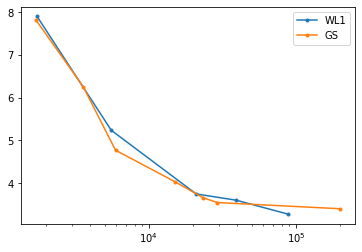

In [103]:
plt.plot(results['parameters'], results['metric'], marker='.', label='WL1')
plt.plot(results_group_sparsity['parameters'], results_group_sparsity['metric'], marker='.', label='GS')
plt.xscale('log')
plt.legend()

In [105]:
import math
0.000002 * math.sqrt(10)

6.324555320336758e-06

In [106]:
schedule1 = Schedule([DynamicEpoch(0.02, 'weighted_l1')] * 20 + [StaticEpochNoRegularization()] * 20)
schedule2 = Schedule([DynamicEpoch(0.0063, 'weighted_l1')] * 20 + [StaticEpochNoRegularization()] * 20)
schedule3 = Schedule([DynamicEpoch(0.002, 'weighted_l1')] * 20 + [StaticEpochNoRegularization()] * 20)
schedule4 = Schedule([DynamicEpoch(0.00063, 'weighted_l1')] * 20 + [StaticEpochNoRegularization()] * 20)
schedule5 = Schedule([DynamicEpoch(0.0002, 'weighted_l1')] * 20 + [StaticEpochNoRegularization()] * 20)
schedule6 = Schedule([DynamicEpoch(0.000063, 'weighted_l1')] * 20 + [StaticEpochNoRegularization()] * 20)
schedule7 = Schedule([DynamicEpoch(0.00002, 'weighted_l1')] * 20 + [StaticEpochNoRegularization()] * 20)
schedule8 = Schedule([DynamicEpoch(0.0000063, 'weighted_l1')] * 20 + [StaticEpochNoRegularization()] * 20)
schedule9 = Schedule([DynamicEpoch(0.000002, 'weighted_l1')] * 20 + [StaticEpochNoRegularization()] * 20)
schedule10 = Schedule([DynamicEpoch(0.00000063, 'weighted_l1')] * 20 + [StaticEpochNoRegularization()] * 20)
schedule1, schedule2, schedule3, schedule4, schedule5, schedule6, schedule7, schedule8, schedule9, schedule10

(63612c7cd8,
 31e8f6ff61,
 e21964ad65,
 b17831153d,
 3d7a8a48c3,
 66b8cbf9fd,
 ec4ba8ef9e,
 fbb780d235,
 aa54b0cdf3,
 f22a62a1d7)

In [107]:
%%time

histories, best_overall_combination = hyperparameter_search(train_fn_dense, x=fifteen_puzzle.X_train_norm, y=fifteen_puzzle.y_train, validation_data=(fifteen_puzzle.X_test_norm, fifteen_puzzle.y_test), 
                                  learning_rate=[0.0001], schedule=[schedule1, schedule2, schedule3, schedule4, schedule5, 
                                                                    schedule6, schedule7, schedule8, schedule9, schedule10], layer_sizes=[[50, 50, 50, 50, 50]], min_new_neurons=[20], growth_percentage=[0.2])

Run with parameters (0.0001, 63612c7cd8, [50, 50, 50, 50, 50], 20, 0.2) completed, best_val_loss: 7.2025017738342285, best_val_metric: 7.202497161356608, best_hidden_layer_sizes: [9, 5, 6, 6, 15]
Run with parameters (0.0001, 31e8f6ff61, [50, 50, 50, 50, 50], 20, 0.2) completed, best_val_loss: 5.903257846832275, best_val_metric: 5.903259393310547, best_hidden_layer_sizes: [14, 8, 10, 7, 20]
Run with parameters (0.0001, e21964ad65, [50, 50, 50, 50, 50], 20, 0.2) completed, best_val_loss: 5.052229881286621, best_val_metric: 5.052232195281983, best_hidden_layer_sizes: [18, 20, 13, 12, 33]
Run with parameters (0.0001, b17831153d, [50, 50, 50, 50, 50], 20, 0.2) completed, best_val_loss: 4.104249954223633, best_val_metric: 4.1042516187032065, best_hidden_layer_sizes: [37, 31, 29, 24, 46]
Run with parameters (0.0001, 3d7a8a48c3, [50, 50, 50, 50, 50], 20, 0.2) completed, best_val_loss: 3.818279504776001, best_val_metric: 3.8182819190979003, best_hidden_layer_sizes: [51, 62, 40, 35, 49]
Run with

In [108]:
results_weighted_l1 = {
    'layer_sizes': [
        [9, 5, 6, 6, 15],
        [14, 8, 10, 7, 20],
        [18, 20, 13, 12, 33],
        [37, 31, 29, 24, 46],
        [51, 62, 40, 35, 49],
        [58, 70, 49, 45, 50],
        [75, 70, 70, 70, 62],
        [116, 78, 70, 71, 70],
        [188, 115, 90, 70, 69],
        [725, 274, 126, 91, 73],
    ],
    'metric': [
        7.202497161356608,
        5.903259393310547,
        5.052232195281983,
        4.1042516187032065,
        3.8182819190979003,
        3.690531215159098,
        3.5561001792907714,
        3.4423048027038576,
        3.3240623718261717,
        3.1492948782602945,
    ],
}

In [109]:
results_weighted_l1['parameters'] = [count_params(layer_sizes) for layer_sizes in results_weighted_l1['layer_sizes']]

Total params: 2,562.0
Trainable params: 2,562
Non-trainable params: 0.0
Total params: 4,066.0
Trainable params: 4,066
Non-trainable params: 0.0
Total params: 5,910.0
Trainable params: 5,910
Non-trainable params: 0.0
Total params: 13,532.0
Trainable params: 13,532
Non-trainable params: 0.0
Total params: 22,100.0
Trainable params: 22,100
Non-trainable params: 0.0
Total params: 27,116.0
Trainable params: 27,116
Non-trainable params: 0.0
Total params: 39,000.0
Trainable params: 39,000
Non-trainable params: 0.0
Total params: 54,620.0
Trainable params: 54,620
Non-trainable params: 0.0
Total params: 91,830.0
Trainable params: 91,830
Non-trainable params: 0.0
Total params: 438,246.0
Trainable params: 438,246
Non-trainable params: 0.0


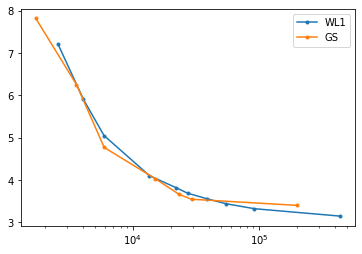

In [110]:
plt.plot(results_weighted_l1['parameters'], results_weighted_l1['metric'], marker='.', label='WL1')
plt.plot(results_group_sparsity['parameters'], results_group_sparsity['metric'], marker='.', label='GS')
plt.xscale('log')
plt.legend()

## Dependency of model size on regularization strength

In [25]:
schedule1 = Schedule([DynamicEpoch(0.02, 'weighted_l1')] * 20)
schedule2 = Schedule([DynamicEpoch(0.002, 'weighted_l1')] * 20)
schedule3 = Schedule([DynamicEpoch(0.0002, 'weighted_l1')] * 20)
schedule4 = Schedule([DynamicEpoch(0.00002, 'weighted_l1')] * 20)
schedule1, schedule2, schedule3, schedule4

(d9d1bf84ba, 6662de7a27, 0610215a13, 718831629c)

In [26]:
def custom_train(schedule):
    histories = list()

    batch_size = 128

    for i in range(5):
        print(f"run {i}...")
        model = get_dense_model(fifteen_puzzle.X_train_norm, layer_sizes=[50, 50, 50, 50, 50])

        optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

        history = model.fit(x=fifteen_puzzle.X_train_norm, y=fifteen_puzzle.y_train, optimizer=optimizer, schedule=schedule, batch_size=batch_size, min_new_neurons=20, 
                            validation_data=(fifteen_puzzle.X_test_norm, fifteen_puzzle.y_test), growth_percentage=0.2, verbose=False, use_static_graph=True,
                            loss_fn=squared_error, metric_fn=squared_error)
        histories.append(history)
    return histories

In [29]:
histories = dict()

In [30]:
%%time
schedule = schedule1
histories[str(schedule)] = custom_train(schedule)
[history['hidden_layer_sizes'] for history in histories[str(schedule)]]

run 0...
run 1...
run 2...
run 3...
run 4...
CPU times: user 48min 49s, sys: 4min 35s, total: 53min 25s
Wall time: 41min 10s


[[[48, 49, 44, 49, 44],
  [33, 20, 18, 16, 28],
  [24, 13, 13, 13, 25],
  [18, 11, 13, 11, 22],
  [16, 11, 10, 10, 20],
  [14, 9, 10, 10, 20],
  [13, 9, 9, 9, 19],
  [13, 8, 8, 8, 19],
  [12, 8, 8, 8, 17],
  [10, 6, 6, 7, 17],
  [9, 6, 6, 6, 15],
  [9, 6, 6, 6, 15],
  [9, 6, 6, 6, 12],
  [8, 6, 6, 6, 11],
  [8, 5, 6, 6, 11],
  [8, 5, 5, 5, 11],
  [8, 5, 5, 5, 11],
  [7, 5, 4, 5, 11],
  [7, 5, 4, 5, 11],
  [7, 5, 4, 5, 11]],
 [[49, 50, 50, 50, 44],
  [35, 18, 20, 15, 37],
  [25, 9, 18, 6, 35],
  [19, 8, 16, 4, 31],
  [18, 8, 16, 3, 29],
  [15, 7, 16, 3, 28],
  [14, 7, 16, 3, 28],
  [13, 7, 16, 2, 28],
  [12, 7, 16, 2, 28],
  [12, 6, 16, 2, 26],
  [10, 6, 15, 2, 26],
  [9, 6, 14, 2, 26],
  [8, 6, 13, 2, 25],
  [8, 6, 13, 2, 25],
  [8, 5, 12, 2, 24],
  [8, 5, 11, 2, 24],
  [8, 4, 11, 2, 23],
  [8, 4, 11, 2, 23],
  [8, 4, 11, 2, 21],
  [8, 4, 10, 2, 21]],
 [[49, 48, 47, 49, 46],
  [37, 23, 18, 14, 35],
  [28, 16, 14, 11, 32],
  [20, 13, 12, 9, 31],
  [17, 12, 11, 8, 29],
  [14, 12, 9, 8, 2

In [31]:
%%time
schedule = schedule2
histories[str(schedule)] = custom_train(schedule)
[history['hidden_layer_sizes'] for history in histories[str(schedule)]]

run 0...
run 1...
run 2...
run 3...
run 4...
CPU times: user 49min 28s, sys: 4min 41s, total: 54min 10s
Wall time: 41min 19s


[[[70, 50, 50, 50, 50],
  [70, 49, 46, 49, 50],
  [67, 43, 41, 40, 50],
  [65, 36, 34, 37, 47],
  [60, 35, 31, 32, 46],
  [53, 29, 28, 30, 44],
  [45, 26, 24, 27, 44],
  [34, 25, 22, 25, 42],
  [32, 22, 21, 23, 40],
  [28, 22, 20, 21, 38],
  [26, 22, 20, 21, 37],
  [24, 21, 19, 18, 37],
  [22, 21, 19, 18, 37],
  [21, 21, 19, 16, 36],
  [21, 19, 18, 16, 35],
  [21, 19, 18, 14, 33],
  [21, 18, 18, 14, 33],
  [19, 18, 18, 13, 32],
  [18, 18, 17, 13, 31],
  [17, 18, 17, 13, 31]],
 [[70, 50, 50, 50, 70],
  [70, 49, 46, 44, 50],
  [69, 45, 36, 38, 49],
  [64, 37, 32, 31, 46],
  [59, 34, 30, 27, 44],
  [56, 32, 29, 23, 43],
  [54, 30, 28, 20, 39],
  [47, 25, 23, 17, 39],
  [42, 24, 23, 16, 38],
  [37, 24, 21, 16, 36],
  [33, 23, 21, 15, 34],
  [29, 23, 20, 15, 32],
  [27, 22, 20, 15, 31],
  [24, 22, 20, 14, 31],
  [23, 20, 20, 14, 31],
  [23, 20, 20, 13, 29],
  [21, 20, 20, 13, 29],
  [20, 19, 18, 13, 28],
  [19, 18, 17, 13, 26],
  [19, 17, 17, 13, 26]],
 [[70, 50, 50, 50, 50],
  [70, 46, 46,

In [32]:
%%time
schedule = schedule3
histories[str(schedule)] = custom_train(schedule)
[history['hidden_layer_sizes'] for history in histories[str(schedule)]]

run 0...
run 1...
run 2...
run 3...
run 4...
CPU times: user 48min 6s, sys: 4min 20s, total: 52min 27s
Wall time: 40min 10s


[[[70, 70, 70, 70, 70],
  [70, 70, 70, 70, 52],
  [70, 70, 70, 69, 48],
  [70, 70, 70, 55, 48],
  [70, 70, 66, 47, 48],
  [69, 70, 53, 47, 46],
  [68, 70, 48, 45, 46],
  [59, 70, 46, 45, 46],
  [58, 70, 45, 45, 46],
  [56, 70, 42, 44, 46],
  [54, 70, 41, 43, 46],
  [54, 70, 39, 42, 46],
  [54, 70, 39, 41, 46],
  [54, 70, 38, 41, 45],
  [54, 70, 36, 41, 45],
  [54, 70, 36, 41, 45],
  [53, 69, 35, 41, 44],
  [53, 69, 34, 40, 44],
  [53, 66, 34, 40, 44],
  [52, 62, 34, 40, 44]],
 [[70, 70, 70, 70, 70],
  [70, 70, 70, 70, 70],
  [70, 70, 70, 69, 62],
  [70, 70, 68, 49, 55],
  [70, 70, 57, 49, 50],
  [70, 69, 48, 49, 50],
  [70, 69, 46, 47, 50],
  [67, 69, 46, 47, 50],
  [66, 68, 44, 47, 50],
  [65, 68, 43, 46, 50],
  [65, 68, 43, 44, 50],
  [63, 68, 42, 44, 50],
  [62, 68, 42, 43, 50],
  [61, 67, 42, 41, 50],
  [59, 65, 41, 41, 50],
  [58, 60, 41, 39, 50],
  [58, 56, 40, 39, 50],
  [57, 53, 39, 37, 50],
  [57, 49, 38, 37, 50],
  [56, 47, 37, 37, 50]],
 [[70, 70, 70, 70, 70],
  [70, 70, 70,

In [33]:
%%time
schedule = schedule4
histories[str(schedule)] = custom_train(schedule)
[history['hidden_layer_sizes'] for history in histories[str(schedule)]]

run 0...
run 1...
run 2...
run 3...
run 4...
CPU times: user 50min 22s, sys: 4min 56s, total: 55min 18s
Wall time: 42min 2s


[[[70, 70, 70, 70, 70],
  [82, 70, 70, 70, 70],
  [81, 70, 70, 70, 70],
  [81, 70, 70, 70, 70],
  [81, 70, 70, 70, 69],
  [81, 70, 70, 70, 69],
  [81, 70, 70, 70, 69],
  [81, 70, 70, 70, 69],
  [81, 70, 70, 70, 69],
  [81, 70, 70, 70, 69],
  [80, 70, 70, 70, 68],
  [80, 70, 70, 69, 66],
  [80, 70, 70, 69, 64],
  [80, 70, 70, 69, 64],
  [80, 70, 70, 69, 64],
  [80, 70, 70, 69, 63],
  [79, 70, 70, 69, 61],
  [79, 70, 70, 69, 59],
  [79, 70, 70, 68, 56],
  [78, 70, 70, 68, 55]],
 [[70, 70, 70, 70, 70],
  [77, 71, 70, 70, 70],
  [77, 70, 70, 70, 70],
  [76, 70, 70, 70, 70],
  [76, 70, 70, 70, 70],
  [76, 70, 70, 70, 70],
  [76, 70, 70, 70, 70],
  [76, 70, 70, 70, 69],
  [76, 70, 70, 70, 68],
  [76, 70, 70, 70, 64],
  [76, 70, 70, 70, 59],
  [76, 70, 70, 70, 54],
  [76, 70, 70, 70, 52],
  [76, 70, 70, 70, 50],
  [76, 70, 70, 69, 49],
  [76, 70, 70, 69, 49],
  [76, 70, 70, 69, 49],
  [76, 70, 70, 69, 49],
  [76, 70, 70, 69, 49],
  [76, 70, 70, 69, 49]],
 [[70, 70, 70, 70, 70],
  [83, 70, 70,

In [34]:
histories

{'d9d1bf84ba': [{'loss': [<tf.Tensor: shape=(), dtype=float32, numpy=143.85413>,
    <tf.Tensor: shape=(), dtype=float32, numpy=10.265999>,
    <tf.Tensor: shape=(), dtype=float32, numpy=10.114917>,
    <tf.Tensor: shape=(), dtype=float32, numpy=9.975893>,
    <tf.Tensor: shape=(), dtype=float32, numpy=9.815293>,
    <tf.Tensor: shape=(), dtype=float32, numpy=9.663369>,
    <tf.Tensor: shape=(), dtype=float32, numpy=9.514323>,
    <tf.Tensor: shape=(), dtype=float32, numpy=9.391406>,
    <tf.Tensor: shape=(), dtype=float32, numpy=9.281445>,
    <tf.Tensor: shape=(), dtype=float32, numpy=9.173537>,
    <tf.Tensor: shape=(), dtype=float32, numpy=9.084564>,
    <tf.Tensor: shape=(), dtype=float32, numpy=8.99186>,
    <tf.Tensor: shape=(), dtype=float32, numpy=8.89528>,
    <tf.Tensor: shape=(), dtype=float32, numpy=8.809052>,
    <tf.Tensor: shape=(), dtype=float32, numpy=8.722276>,
    <tf.Tensor: shape=(), dtype=float32, numpy=8.649298>,
    <tf.Tensor: shape=(), dtype=float32, numpy=8.

In [37]:
histories_bak = histories.copy()

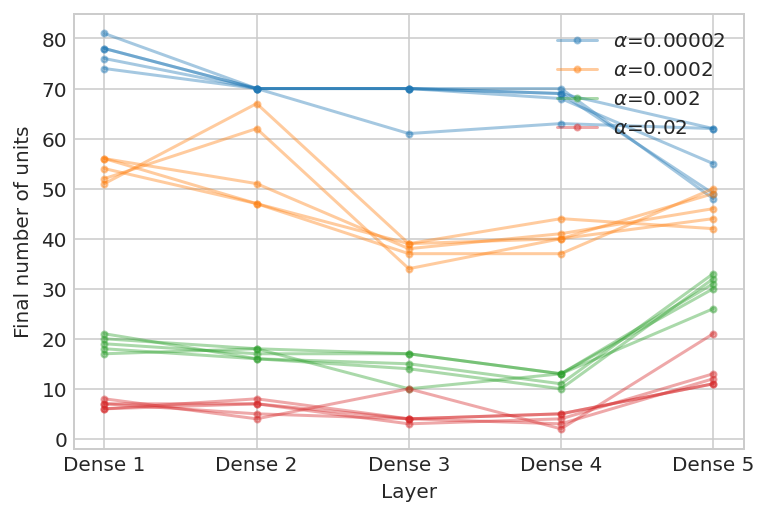

In [76]:
for regularization_penalty, histories_of_same_penalty, color in zip(reversed([0.02, 0.002, 0.0002, 0.00002]), reversed(histories.values()), ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']):
    for i, history in enumerate(histories_of_same_penalty):
        if i == 0:
            label = f"$\\alpha$={np.format_float_positional(regularization_penalty, trim='-')}"
        else:
            label = None
        metric = history['hidden_layer_sizes'][-1]
        plt.plot(['Dense 1', 'Dense 2', 'Dense 3', 'Dense 4', 'Dense 5'], metric, label=label, c=color, marker='.', alpha=0.4)
plt.xlabel("Layer")
plt.ylabel("Final number of units")
legend = plt.legend(loc='upper right')
plt.savefig('model-size-different-regularization.png')
# plt.yscale('log')

# Legacy code

In [ ]:
learning_rates = [0.0001 * 2 ** i for i in range(7)]
learning_rates

[0.0001, 0.0002, 0.0004, 0.0008, 0.0016, 0.0032, 0.0064]

## CIFAR100

In [ ]:
cifar100 = get_cifar_100_dataset()

169017344/169001437 [==============================] - 6s 0us/step


In [ ]:
%%time

schedule = Schedule([DynamicEpoch(0.00002, 'weighted_l1')] * 20 + [StaticEpochNoRegularization()] * 20)
histories, best_overall_combination = hyperparameter_search(train_fn, x=cifar100.X_train_norm, y=cifar100.y_train, validation_data=(cifar100.X_test_norm, cifar100.y_test), 
                                  learning_rate=[0.0001, 0.0002, 0.0004], schedule=[schedule], layer_sizes=[[100, 100, 100, 100, 100]], 
                                  output_neurons=[100], min_new_neurons=[20], growth_percentage=[0.2])

Run with parameters (0.0001, ec4ba8ef9e, [100, 100, 100, 100, 100], 100, 20, 0.2) completed, best_val_accuracy: 0.44, best_hidden_layer_sizes sizes: [90, 29, 38, 43, 100]
Run with parameters (0.0002, ec4ba8ef9e, [100, 100, 100, 100, 100], 100, 20, 0.2) completed, best_val_accuracy: 0.4448, best_hidden_layer_sizes sizes: [67, 23, 27, 73, 195]
Run with parameters (0.0004, ec4ba8ef9e, [100, 100, 100, 100, 100], 100, 20, 0.2) completed, best_val_accuracy: 0.4358, best_hidden_layer_sizes sizes: [60, 18, 55, 120, 452]
Best overall combination: (0.0002, ec4ba8ef9e, [100, 100, 100, 100, 100], 100, 20, 0.2), val_accuracy: 0.4448
CPU times: user 9min 57s, sys: 20.8 s, total: 10min 18s
Wall time: 9min 3s


In [ ]:
best_learning_rate = best_overall_combination[0]
best_learning_rate

0.0002

In [ ]:
%%time

schedule = Schedule([DynamicEpoch(0.00002, 'weighted_l1')] * 20 + [StaticEpochNoRegularization()] * 20)
histories, mean_best_hidden_layer_sizes = cross_validate(
    train_fn, cifar100.X_norm, cifar100.y, n_splits=6, learning_rate=best_learning_rate,
    schedule=schedule, layer_sizes=[100, 100, 100, 100, 100], output_neurons=100, min_new_neurons=20, growth_percentage=0.2
)

Run 0 completed, best_val_accuracy: 0.4428, best_hidden_layer_sizes: [68, 19, 33, 74, 191]
Run 1 completed, best_val_accuracy: 0.4512, best_hidden_layer_sizes: [62, 22, 29, 61, 195]
Run 2 completed, best_val_accuracy: 0.4484, best_hidden_layer_sizes: [67, 19, 30, 61, 200]
Run 3 completed, best_val_accuracy: 0.4485, best_hidden_layer_sizes: [67, 18, 33, 63, 199]
Run 4 completed, best_val_accuracy: 0.4577, best_hidden_layer_sizes: [62, 20, 27, 62, 190]
Run 5 completed, best_val_accuracy: 0.457, best_hidden_layer_sizes: [69, 23, 28, 66, 192]
mean_best_val_accuracy: 0.45093333333333335
mean_best_hidden_layer_sizes: [65.83333333333333, 20.166666666666668, 30.0, 64.5, 194.5]
CPU times: user 19min 26s, sys: 41.6 s, total: 20min 8s
Wall time: 17min 17s


In [ ]:
rounded_mean_best_hidden_layer_sizes = [round(x) for x in mean_best_hidden_layer_sizes]
rounded_mean_best_hidden_layer_sizes

[66, 20, 30, 64, 194]

In [ ]:
%%time

schedule = Schedule([StaticEpochNoRegularization()] * 40)
histories, best_overall_combination = hyperparameter_search(train_fn, x=cifar100.X_train_norm, y=cifar100.y_train, validation_data=(cifar100.X_test_norm, cifar100.y_test), 
                                  learning_rate=[0.0001, 0.0002, 0.0004, 0.0008, 0.0016], schedule=[schedule], layer_sizes=[rounded_mean_best_hidden_layer_sizes], 
                                  output_neurons=[100], min_new_neurons=[20], growth_percentage=[0.2])

Run with parameters (0.0001, 4a0f172746, [66, 20, 30, 64, 194], 100, 20, 0.2) completed, best_val_accuracy: 0.3397, best_hidden_layer_sizes sizes: [66, 20, 30, 64, 194]
Run with parameters (0.0002, 4a0f172746, [66, 20, 30, 64, 194], 100, 20, 0.2) completed, best_val_accuracy: 0.3392, best_hidden_layer_sizes sizes: [66, 20, 30, 64, 194]
Run with parameters (0.0004, 4a0f172746, [66, 20, 30, 64, 194], 100, 20, 0.2) completed, best_val_accuracy: 0.334, best_hidden_layer_sizes sizes: [66, 20, 30, 64, 194]
Run with parameters (0.0008, 4a0f172746, [66, 20, 30, 64, 194], 100, 20, 0.2) completed, best_val_accuracy: 0.3272, best_hidden_layer_sizes sizes: [66, 20, 30, 64, 194]
Run with parameters (0.0016, 4a0f172746, [66, 20, 30, 64, 194], 100, 20, 0.2) completed, best_val_accuracy: 0.3199, best_hidden_layer_sizes sizes: [66, 20, 30, 64, 194]
Best overall combination: (0.0001, 4a0f172746, [66, 20, 30, 64, 194], 100, 20, 0.2), val_accuracy: 0.3397
CPU times: user 11min 56s, sys: 29 s, total: 12min

In [ ]:
best_learning_rate = best_overall_combination[0]
best_learning_rate

0.0001

In [ ]:
%%time

schedule = Schedule([StaticEpochNoRegularization()] * 40)
histories, mean_best_hidden_layer_sizes = cross_validate(
    train_fn, cifar100.X_norm, cifar100.y, n_splits=6, learning_rate=best_learning_rate,
    schedule=schedule, layer_sizes=rounded_mean_best_hidden_layer_sizes, output_neurons=100, min_new_neurons=20, growth_percentage=0.2
)

Run 0 completed, best_val_accuracy: 0.3183, best_hidden_layer_sizes: [66, 20, 30, 64, 194]
Run 1 completed, best_val_accuracy: 0.3265, best_hidden_layer_sizes: [66, 20, 30, 64, 194]
Run 2 completed, best_val_accuracy: 0.3134, best_hidden_layer_sizes: [66, 20, 30, 64, 194]
Run 3 completed, best_val_accuracy: 0.3345, best_hidden_layer_sizes: [66, 20, 30, 64, 194]
Run 4 completed, best_val_accuracy: 0.325, best_hidden_layer_sizes: [66, 20, 30, 64, 194]
Run 5 completed, best_val_accuracy: 0.3234, best_hidden_layer_sizes: [66, 20, 30, 64, 194]
mean_best_val_accuracy: 0.3235166666666667
mean_best_hidden_layer_sizes: [66.0, 20.0, 30.0, 64.0, 194.0]
CPU times: user 14min 32s, sys: 34.6 s, total: 15min 7s
Wall time: 11min 33s


## Street View House Numbers

In [ ]:
svhn = get_svhn_dataset()

In [ ]:
%%time

schedule = Schedule([DynamicEpoch(0.00002, 'weighted_l1')] * 20 + [StaticEpochNoRegularization()] * 20)
histories, best_overall_combination = hyperparameter_search(train_fn, x=svhn.X_train_norm, y=svhn.y_train, validation_data=(svhn.X_test_norm, svhn.y_test), 
                                  learning_rate=[0.0001, 0.0002, 0.0004], schedule=[schedule], layer_sizes=[[100, 100, 100, 100, 100]], 
                                  output_neurons=[10], min_new_neurons=[20], growth_percentage=[0.2])

Run with parameters (0.0001, ec4ba8ef9e, [100, 100, 100, 100, 100], 10, 20, 0.2) completed, best_val_accuracy: 0.9225568531038721, best_hidden_layer_sizes sizes: [35, 23, 18, 49, 56]
Run with parameters (0.0002, ec4ba8ef9e, [100, 100, 100, 100, 100], 10, 20, 0.2) completed, best_val_accuracy: 0.9231330669944684, best_hidden_layer_sizes sizes: [23, 16, 18, 43, 68]
Run with parameters (0.0004, ec4ba8ef9e, [100, 100, 100, 100, 100], 10, 20, 0.2) completed, best_val_accuracy: 0.9256684081130916, best_hidden_layer_sizes sizes: [17, 15, 27, 42, 172]
Best overall combination: (0.0004, ec4ba8ef9e, [100, 100, 100, 100, 100], 10, 20, 0.2), val_accuracy: 0.9256684081130916
CPU times: user 15min 7s, sys: 33.3 s, total: 15min 41s
Wall time: 12min 49s


In [ ]:
best_learning_rate = best_overall_combination[0]
best_learning_rate

0.0004

In [ ]:
%%time

schedule = Schedule([DynamicEpoch(0.00002, 'weighted_l1')] * 20 + [StaticEpochNoRegularization()] * 20)
histories, mean_best_hidden_layer_sizes = cross_validate(
    train_fn, svhn.X_norm, svhn.y, n_splits=4, learning_rate=best_learning_rate,
    schedule=schedule, layer_sizes=[100, 100, 100, 100, 100], output_neurons=10, min_new_neurons=20, growth_percentage=0.2
)

Run 0 completed, best_val_accuracy: 0.9326431132417516, best_hidden_layer_sizes: [19, 16, 17, 41, 148]
Run 1 completed, best_val_accuracy: 0.9331238417532833, best_hidden_layer_sizes: [15, 17, 27, 48, 169]
Run 2 completed, best_val_accuracy: 0.9300217548948514, best_hidden_layer_sizes: [18, 16, 19, 51, 158]
Run 3 completed, best_val_accuracy: 0.929981468052534, best_hidden_layer_sizes: [16, 17, 21, 41, 159]
mean_best_val_accuracy: 0.9314425444856052
mean_best_hidden_layer_sizes: [17.0, 16.5, 21.0, 45.25, 158.5]
CPU times: user 19min 51s, sys: 46.1 s, total: 20min 37s
Wall time: 16min 40s


In [ ]:
rounded_mean_best_hidden_layer_sizes = [round(x) for x in mean_best_hidden_layer_sizes]
rounded_mean_best_hidden_layer_sizes

[17, 16, 21, 45, 158]

In [ ]:
%%time

schedule = Schedule([StaticEpochNoRegularization()] * 40)
histories, best_overall_combination = hyperparameter_search(train_fn, x=svhn.X_train_norm, y=svhn.y_train, validation_data=(svhn.X_test_norm, svhn.y_test), 
                                  learning_rate=[0.0001, 0.0002, 0.0004, 0.0008, 0.0016], schedule=[schedule], layer_sizes=[rounded_mean_best_hidden_layer_sizes], 
                                  output_neurons=[10], min_new_neurons=[20], growth_percentage=[0.2])

Run with parameters (0.0001, 4a0f172746, [17, 16, 21, 45, 158], 10, 20, 0.2) completed, best_val_accuracy: 0.8831438229870928, best_hidden_layer_sizes sizes: [17, 16, 21, 45, 158]
Run with parameters (0.0002, 4a0f172746, [17, 16, 21, 45, 158], 10, 20, 0.2) completed, best_val_accuracy: 0.8705055316533498, best_hidden_layer_sizes sizes: [17, 16, 21, 45, 158]
Run with parameters (0.0004, 4a0f172746, [17, 16, 21, 45, 158], 10, 20, 0.2) completed, best_val_accuracy: 0.8845651505838967, best_hidden_layer_sizes sizes: [17, 16, 21, 45, 158]
Run with parameters (0.0008, 4a0f172746, [17, 16, 21, 45, 158], 10, 20, 0.2) completed, best_val_accuracy: 0.9056929932390904, best_hidden_layer_sizes sizes: [17, 16, 21, 45, 158]
Run with parameters (0.0016, 4a0f172746, [17, 16, 21, 45, 158], 10, 20, 0.2) completed, best_val_accuracy: 0.8907882606023356, best_hidden_layer_sizes sizes: [17, 16, 21, 45, 158]
Best overall combination: (0.0008, 4a0f172746, [17, 16, 21, 45, 158], 10, 20, 0.2), val_accuracy: 0.

In [ ]:
best_learning_rate = best_overall_combination[0]
best_learning_rate

0.0008

In [ ]:
%%time

schedule = Schedule([StaticEpochNoRegularization()] * 40)
histories, mean_best_hidden_layer_sizes = cross_validate(
    train_fn, svhn.X_norm, svhn.y, n_splits=4, learning_rate=best_learning_rate,
    schedule=schedule, layer_sizes=rounded_mean_best_hidden_layer_sizes, output_neurons=10, min_new_neurons=20, growth_percentage=0.2
)

Run 0 completed, best_val_accuracy: 0.9115739435201224, best_hidden_layer_sizes: [17, 16, 21, 45, 158]
Run 1 completed, best_val_accuracy: 0.9151559100797679, best_hidden_layer_sizes: [17, 16, 21, 45, 158]
Run 2 completed, best_val_accuracy: 0.9182177100958827, best_hidden_layer_sizes: [17, 16, 21, 45, 158]
Run 3 completed, best_val_accuracy: 0.9090725968898558, best_hidden_layer_sizes: [17, 16, 21, 45, 158]
mean_best_val_accuracy: 0.9135050401464072
mean_best_hidden_layer_sizes: [17.0, 16.0, 21.0, 45.0, 158.0]
CPU times: user 15min 31s, sys: 39.8 s, total: 16min 11s
Wall time: 12min 19s


##CIFAR10

In [ ]:
cifar10 = get_cifar_10_dataset()

170508288/170498071 [==============================] - 6s 0us/step


In [ ]:
%%time

schedule = Schedule([DynamicEpoch(0.00002, 'weighted_l1')] * 20 + [StaticEpochNoRegularization()] * 20)
histories, best_overall_combination = hyperparameter_search(train_fn, x=cifar10.X_train_norm, y=cifar10.y_train, validation_data=(cifar10.X_test_norm, cifar10.y_test), 
                                  learning_rate=[0.0001, 0.0002, 0.0004], schedule=[schedule], layer_sizes=[[100, 100, 100, 100, 100]], 
                                  output_neurons=[10], min_new_neurons=[20], growth_percentage=[0.2])

Run with parameters (0.0001, ec4ba8ef9e, [100, 100, 100, 100, 100], 10, 20, 0.2) completed, best_val_accuracy: 0.7309, best_hidden_layer_sizes sizes: [86, 24, 32, 48, 51]
Run with parameters (0.0002, ec4ba8ef9e, [100, 100, 100, 100, 100], 10, 20, 0.2) completed, best_val_accuracy: 0.7502, best_hidden_layer_sizes sizes: [58, 18, 25, 48, 78]
Run with parameters (0.0004, ec4ba8ef9e, [100, 100, 100, 100, 100], 10, 20, 0.2) completed, best_val_accuracy: 0.7699, best_hidden_layer_sizes sizes: [38, 20, 21, 56, 161]
Best overall combination: (0.0004, ec4ba8ef9e, [100, 100, 100, 100, 100], 10, 20, 0.2), val_accuracy: 0.7699
CPU times: user 9min 51s, sys: 19.3 s, total: 10min 11s
Wall time: 8min 38s


In [ ]:
best_learning_rate = best_overall_combination[0]
best_learning_rate

0.0004

In [ ]:
%%time

schedule = Schedule([DynamicEpoch(0.00002, 'weighted_l1')] * 20 + [StaticEpochNoRegularization()] * 20)
histories, mean_best_hidden_layer_sizes = cross_validate(
    train_fn, cifar10.X_norm, cifar10.y, n_splits=6, learning_rate=best_learning_rate,
    schedule=schedule, layer_sizes=[100, 100, 100, 100, 100], output_neurons=10, min_new_neurons=20, growth_percentage=0.2
)

Run 0 completed, best_val_accuracy: 0.7729, best_hidden_layer_sizes: [41, 16, 27, 59, 215]
Run 1 completed, best_val_accuracy: 0.7684, best_hidden_layer_sizes: [39, 17, 32, 55, 147]
Run 2 completed, best_val_accuracy: 0.773, best_hidden_layer_sizes: [38, 19, 24, 54, 177]
Run 3 completed, best_val_accuracy: 0.7674, best_hidden_layer_sizes: [37, 20, 22, 67, 174]
Run 4 completed, best_val_accuracy: 0.7749, best_hidden_layer_sizes: [38, 18, 26, 57, 145]
Run 5 completed, best_val_accuracy: 0.7662, best_hidden_layer_sizes: [42, 19, 25, 51, 192]
mean_best_val_accuracy: 0.7704666666666666
mean_best_hidden_layer_sizes: [39.166666666666664, 18.166666666666668, 26.0, 57.166666666666664, 175.0]
CPU times: user 19min 26s, sys: 39 s, total: 20min 5s
Wall time: 16min 45s


In [ ]:
rounded_mean_best_hidden_layer_sizes = [round(x) for x in mean_best_hidden_layer_sizes]
rounded_mean_best_hidden_layer_sizes

[39, 18, 26, 57, 175]

In [ ]:
%%time

schedule = Schedule([StaticEpochNoRegularization()] * 40)
histories, best_overall_combination = hyperparameter_search(train_fn, x=cifar10.X_train_norm, y=cifar10.y_train, validation_data=(cifar10.X_test_norm, cifar10.y_test), 
                                  learning_rate=[0.0001, 0.0002, 0.0004, 0.0008, 0.0016, 0.0032], schedule=[schedule], layer_sizes=[rounded_mean_best_hidden_layer_sizes], 
                                  output_neurons=[10], min_new_neurons=[20], growth_percentage=[0.2])

Run with parameters (0.0001, 4a0f172746, [39, 18, 26, 57, 175], 10, 20, 0.2) completed, best_val_accuracy: 0.6574, best_hidden_layer_sizes sizes: [39, 18, 26, 57, 175]
Run with parameters (0.0002, 4a0f172746, [39, 18, 26, 57, 175], 10, 20, 0.2) completed, best_val_accuracy: 0.6557, best_hidden_layer_sizes sizes: [39, 18, 26, 57, 175]
Run with parameters (0.0004, 4a0f172746, [39, 18, 26, 57, 175], 10, 20, 0.2) completed, best_val_accuracy: 0.6811, best_hidden_layer_sizes sizes: [39, 18, 26, 57, 175]
Run with parameters (0.0008, 4a0f172746, [39, 18, 26, 57, 175], 10, 20, 0.2) completed, best_val_accuracy: 0.7077, best_hidden_layer_sizes sizes: [39, 18, 26, 57, 175]
Run with parameters (0.0016, 4a0f172746, [39, 18, 26, 57, 175], 10, 20, 0.2) completed, best_val_accuracy: 0.7281, best_hidden_layer_sizes sizes: [39, 18, 26, 57, 175]
Run with parameters (0.0032, 4a0f172746, [39, 18, 26, 57, 175], 10, 20, 0.2) completed, best_val_accuracy: 0.7032, best_hidden_layer_sizes sizes: [39, 18, 26, 5

In [ ]:
best_learning_rate = best_overall_combination[0]
best_learning_rate

0.0016

In [ ]:
%%time

schedule = Schedule([StaticEpochNoRegularization()] * 40)
histories, mean_best_hidden_layer_sizes = cross_validate(
    train_fn, cifar10.X_norm, cifar10.y, n_splits=6, learning_rate=best_learning_rate,
    schedule=schedule, layer_sizes=rounded_mean_best_hidden_layer_sizes, output_neurons=10, min_new_neurons=20, growth_percentage=0.2
)

Run 0 completed, best_val_accuracy: 0.7312, best_hidden_layer_sizes: [39, 18, 26, 57, 175]
Run 1 completed, best_val_accuracy: 0.7296, best_hidden_layer_sizes: [39, 18, 26, 57, 175]
Run 2 completed, best_val_accuracy: 0.7286, best_hidden_layer_sizes: [39, 18, 26, 57, 175]
Run 3 completed, best_val_accuracy: 0.7299, best_hidden_layer_sizes: [39, 18, 26, 57, 175]
Run 4 completed, best_val_accuracy: 0.7389, best_hidden_layer_sizes: [39, 18, 26, 57, 175]
Run 5 completed, best_val_accuracy: 0.7186, best_hidden_layer_sizes: [39, 18, 26, 57, 175]
mean_best_val_accuracy: 0.7294666666666667
mean_best_hidden_layer_sizes: [39.0, 18.0, 26.0, 57.0, 175.0]
CPU times: user 14min 48s, sys: 38.2 s, total: 15min 26s
Wall time: 11min 49s


## Fashion MNIST

In [ ]:
fashion_mnist = get_fashion_mnist_dataset()

In [ ]:
%%time

schedule = Schedule([DynamicEpoch(0.00002, 'weighted_l1')] * 20 + [StaticEpochNoRegularization()] * 20)
histories, best_overall_combination = hyperparameter_search(train_fn, x=fashion_mnist.X_train_norm, y=fashion_mnist.y_train, validation_data=(fashion_mnist.X_test_norm, fashion_mnist.y_test), 
                                  learning_rate=[0.0001, 0.0002, 0.0004], schedule=[schedule], layer_sizes=[[100, 100, 100, 100, 100]], 
                                  output_neurons=[10], min_new_neurons=[20], growth_percentage=[0.2])

Run with parameters (0.0001, ec4ba8ef9e, [100, 100, 100, 100, 100], 10, 20, 0.2) completed, best_val_accuracy: 0.9215, best_hidden_layer_sizes sizes: [50, 20, 18, 42, 49]
Run with parameters (0.0002, ec4ba8ef9e, [100, 100, 100, 100, 100], 10, 20, 0.2) completed, best_val_accuracy: 0.9263, best_hidden_layer_sizes sizes: [35, 15, 20, 30, 77]
Run with parameters (0.0004, ec4ba8ef9e, [100, 100, 100, 100, 100], 10, 20, 0.2) completed, best_val_accuracy: 0.931, best_hidden_layer_sizes sizes: [28, 13, 28, 31, 119]
Best overall combination: (0.0004, ec4ba8ef9e, [100, 100, 100, 100, 100], 10, 20, 0.2), val_accuracy: 0.931
CPU times: user 8min 13s, sys: 20.3 s, total: 8min 33s
Wall time: 7min 29s


In [ ]:
best_learning_rate = best_overall_combination[0]
best_learning_rate

0.0004

In [ ]:
%%time

schedule = Schedule([DynamicEpoch(0.00002, 'weighted_l1')] * 20 + [StaticEpochNoRegularization()] * 20)
histories, mean_best_hidden_layer_sizes = cross_validate(
    train_fn, fashion_mnist.X_norm, fashion_mnist.y, n_splits=7, learning_rate=best_learning_rate,
    schedule=schedule, layer_sizes=[100, 100, 100, 100, 100], output_neurons=10, min_new_neurons=20, growth_percentage=0.2
)

Run 0 completed, best_val_accuracy: 0.9333, best_hidden_layer_sizes: [25, 15, 24, 35, 121]
Run 1 completed, best_val_accuracy: 0.9314, best_hidden_layer_sizes: [25, 13, 30, 39, 108]
Run 2 completed, best_val_accuracy: 0.9313, best_hidden_layer_sizes: [23, 14, 31, 35, 119]
Run 3 completed, best_val_accuracy: 0.9325, best_hidden_layer_sizes: [22, 14, 12, 40, 113]
Run 4 completed, best_val_accuracy: 0.9384, best_hidden_layer_sizes: [21, 15, 18, 32, 141]
Run 5 completed, best_val_accuracy: 0.9298, best_hidden_layer_sizes: [19, 17, 19, 38, 122]
Run 6 completed, best_val_accuracy: 0.9321, best_hidden_layer_sizes: [20, 15, 15, 33, 143]
mean_best_val_accuracy: 0.9326857142857143
mean_best_hidden_layer_sizes: [22.142857142857142, 14.714285714285714, 21.285714285714285, 36.0, 123.85714285714286]
CPU times: user 19min 2s, sys: 49.2 s, total: 19min 51s
Wall time: 16min 58s


In [ ]:
rounded_mean_best_hidden_layer_sizes = [round(x) for x in mean_best_hidden_layer_sizes]
rounded_mean_best_hidden_layer_sizes

[22, 15, 21, 36, 124]

In [ ]:
%%time

schedule = Schedule([StaticEpochNoRegularization()] * 40)
histories, best_overall_combination = hyperparameter_search(train_fn, x=fashion_mnist.X_train_norm, y=fashion_mnist.y_train, validation_data=(fashion_mnist.X_test_norm, fashion_mnist.y_test), 
                                  learning_rate=[0.0001, 0.0002, 0.0004, 0.0008, 0.0016, 0.0032], schedule=[schedule], layer_sizes=[rounded_mean_best_hidden_layer_sizes], 
                                  output_neurons=[10], min_new_neurons=[20], growth_percentage=[0.2])

Run with parameters (0.0001, 4a0f172746, [22, 15, 21, 36, 124], 10, 20, 0.2) completed, best_val_accuracy: 0.9066, best_hidden_layer_sizes sizes: [22, 15, 21, 36, 124]
Run with parameters (0.0002, 4a0f172746, [22, 15, 21, 36, 124], 10, 20, 0.2) completed, best_val_accuracy: 0.9126, best_hidden_layer_sizes sizes: [22, 15, 21, 36, 124]
Run with parameters (0.0004, 4a0f172746, [22, 15, 21, 36, 124], 10, 20, 0.2) completed, best_val_accuracy: 0.921, best_hidden_layer_sizes sizes: [22, 15, 21, 36, 124]
Run with parameters (0.0008, 4a0f172746, [22, 15, 21, 36, 124], 10, 20, 0.2) completed, best_val_accuracy: 0.9189, best_hidden_layer_sizes sizes: [22, 15, 21, 36, 124]
Run with parameters (0.0016, 4a0f172746, [22, 15, 21, 36, 124], 10, 20, 0.2) completed, best_val_accuracy: 0.9187, best_hidden_layer_sizes sizes: [22, 15, 21, 36, 124]
Run with parameters (0.0032, 4a0f172746, [22, 15, 21, 36, 124], 10, 20, 0.2) completed, best_val_accuracy: 0.9066, best_hidden_layer_sizes sizes: [22, 15, 21, 36

In [ ]:
best_learning_rate = best_overall_combination[0]
best_learning_rate

0.0004

In [ ]:
%%time

schedule = Schedule([StaticEpochNoRegularization()] * 40)
histories, mean_best_hidden_layer_sizes = cross_validate(
    train_fn, fashion_mnist.X_norm, fashion_mnist.y, n_splits=7, learning_rate=best_learning_rate,
    schedule=schedule, layer_sizes=rounded_mean_best_hidden_layer_sizes, output_neurons=10, min_new_neurons=20, growth_percentage=0.2
)

Run 0 completed, best_val_accuracy: 0.923, best_hidden_layer_sizes: [22, 15, 21, 36, 124]
Run 1 completed, best_val_accuracy: 0.9246, best_hidden_layer_sizes: [22, 15, 21, 36, 124]
Run 2 completed, best_val_accuracy: 0.9233, best_hidden_layer_sizes: [22, 15, 21, 36, 124]
Run 3 completed, best_val_accuracy: 0.9269, best_hidden_layer_sizes: [22, 15, 21, 36, 124]
Run 4 completed, best_val_accuracy: 0.9218, best_hidden_layer_sizes: [22, 15, 21, 36, 124]
Run 5 completed, best_val_accuracy: 0.9249, best_hidden_layer_sizes: [22, 15, 21, 36, 124]
Run 6 completed, best_val_accuracy: 0.9231, best_hidden_layer_sizes: [22, 15, 21, 36, 124]
mean_best_val_accuracy: 0.9239428571428572
mean_best_hidden_layer_sizes: [22.0, 15.0, 21.0, 36.0, 124.0]
CPU times: user 15min 17s, sys: 41 s, total: 15min 58s
Wall time: 12min 44s


## MNIST

In [ ]:
mnist = get_mnist_dataset()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
%%time

schedule = Schedule([DynamicEpoch(0.00002, 'weighted_l1')] * 20 + [StaticEpochNoRegularization()] * 20)
histories, best_overall_combination = hyperparameter_search(train_fn, x=mnist.X_train_norm, y=mnist.y_train, validation_data=(mnist.X_test_norm, mnist.y_test), 
                                  learning_rate=[0.0001, 0.0002, 0.0004], schedule=[schedule], layer_sizes=[[100, 100, 100, 100, 100]], 
                                  output_neurons=[10], min_new_neurons=[20], growth_percentage=[0.2])

Run with parameters (0.0001, ec4ba8ef9e, [100, 100, 100, 100, 100], 10, 20, 0.2) completed, best_val_accuracy: 0.9924, best_hidden_layer_sizes sizes: [36, 20, 18, 35, 44]
Run with parameters (0.0002, ec4ba8ef9e, [100, 100, 100, 100, 100], 10, 20, 0.2) completed, best_val_accuracy: 0.9931, best_hidden_layer_sizes sizes: [19, 19, 14, 31, 39]
Run with parameters (0.0004, ec4ba8ef9e, [100, 100, 100, 100, 100], 10, 20, 0.2) completed, best_val_accuracy: 0.9933, best_hidden_layer_sizes sizes: [16, 14, 19, 45, 109]
Best overall combination: (0.0004, ec4ba8ef9e, [100, 100, 100, 100, 100], 10, 20, 0.2), val_accuracy: 0.9933
CPU times: user 8min 4s, sys: 20.5 s, total: 8min 25s
Wall time: 7min 18s


In [ ]:
best_learning_rate = best_overall_combination[0]
best_learning_rate

0.0004

In [ ]:
%%time

schedule = Schedule([DynamicEpoch(0.00002, 'weighted_l1')] * 20 + [StaticEpochNoRegularization()] * 20)
histories, mean_best_hidden_layer_sizes = cross_validate(
    train_fn, mnist.X_norm, mnist.y, n_splits=7, learning_rate=best_learning_rate,
    schedule=schedule, layer_sizes=[100, 100, 100, 100, 100], output_neurons=10, min_new_neurons=20, growth_percentage=0.2
)

Run 0 completed, best_val_accuracy: 0.9926, best_hidden_layer_sizes: [18, 15, 16, 34, 77]
Run 1 completed, best_val_accuracy: 0.9936, best_hidden_layer_sizes: [16, 13, 16, 38, 91]
Run 2 completed, best_val_accuracy: 0.9928, best_hidden_layer_sizes: [20, 13, 14, 32, 102]
Run 3 completed, best_val_accuracy: 0.9938, best_hidden_layer_sizes: [18, 14, 16, 35, 81]
Run 4 completed, best_val_accuracy: 0.9946, best_hidden_layer_sizes: [18, 14, 19, 31, 88]
Run 5 completed, best_val_accuracy: 0.9933, best_hidden_layer_sizes: [17, 16, 13, 34, 113]
Run 6 completed, best_val_accuracy: 0.994, best_hidden_layer_sizes: [23, 14, 29, 31, 100]
mean_best_val_accuracy: 0.9935285714285714
mean_best_hidden_layer_sizes: [18.571428571428573, 14.142857142857142, 17.571428571428573, 33.57142857142857, 93.14285714285714]
CPU times: user 18min 40s, sys: 50.5 s, total: 19min 31s
Wall time: 16min 42s


In [ ]:
rounded_mean_best_hidden_layer_sizes = [round(x) for x in mean_best_hidden_layer_sizes]
rounded_mean_best_hidden_layer_sizes

[19, 14, 18, 34, 93]

In [ ]:
%%time

schedule = Schedule([StaticEpochNoRegularization()] * 40)
histories, best_overall_combination = hyperparameter_search(train_fn, x=mnist.X_train_norm, y=mnist.y_train, validation_data=(mnist.X_test_norm, mnist.y_test), 
                                  learning_rate=[0.0001, 0.0002, 0.0004, 0.0008, 0.0016, 0.0032], schedule=[schedule], layer_sizes=[rounded_mean_best_hidden_layer_sizes], 
                                  output_neurons=[10], min_new_neurons=[20], growth_percentage=[0.2])

Run with parameters (0.0001, 4a0f172746, [19, 14, 18, 34, 93], 10, 20, 0.2) completed, best_val_accuracy: 0.9917, best_hidden_layer_sizes sizes: [19, 14, 18, 34, 93]
Run with parameters (0.0002, 4a0f172746, [19, 14, 18, 34, 93], 10, 20, 0.2) completed, best_val_accuracy: 0.9925, best_hidden_layer_sizes sizes: [19, 14, 18, 34, 93]
Run with parameters (0.0004, 4a0f172746, [19, 14, 18, 34, 93], 10, 20, 0.2) completed, best_val_accuracy: 0.9929, best_hidden_layer_sizes sizes: [19, 14, 18, 34, 93]
Run with parameters (0.0008, 4a0f172746, [19, 14, 18, 34, 93], 10, 20, 0.2) completed, best_val_accuracy: 0.9919, best_hidden_layer_sizes sizes: [19, 14, 18, 34, 93]
Run with parameters (0.0016, 4a0f172746, [19, 14, 18, 34, 93], 10, 20, 0.2) completed, best_val_accuracy: 0.9925, best_hidden_layer_sizes sizes: [19, 14, 18, 34, 93]
Run with parameters (0.0032, 4a0f172746, [19, 14, 18, 34, 93], 10, 20, 0.2) completed, best_val_accuracy: 0.9902, best_hidden_layer_sizes sizes: [19, 14, 18, 34, 93]
Best

In [ ]:
best_learning_rate = best_overall_combination[0]
best_learning_rate

0.0004

In [ ]:
%%time

schedule = Schedule([StaticEpochNoRegularization()] * 40)
histories, mean_best_hidden_layer_sizes = cross_validate(
    train_fn, mnist.X_norm, mnist.y, n_splits=7, learning_rate=best_learning_rate,
    schedule=schedule, layer_sizes=rounded_mean_best_hidden_layer_sizes, output_neurons=10, min_new_neurons=20, growth_percentage=0.2
)

Run 0 completed, best_val_accuracy: 0.9923, best_hidden_layer_sizes: [19, 14, 18, 34, 93]
Run 1 completed, best_val_accuracy: 0.9935, best_hidden_layer_sizes: [19, 14, 18, 34, 93]
Run 2 completed, best_val_accuracy: 0.9937, best_hidden_layer_sizes: [19, 14, 18, 34, 93]
Run 3 completed, best_val_accuracy: 0.9932, best_hidden_layer_sizes: [19, 14, 18, 34, 93]
Run 4 completed, best_val_accuracy: 0.9941, best_hidden_layer_sizes: [19, 14, 18, 34, 93]
Run 5 completed, best_val_accuracy: 0.9924, best_hidden_layer_sizes: [19, 14, 18, 34, 93]
Run 6 completed, best_val_accuracy: 0.9943, best_hidden_layer_sizes: [19, 14, 18, 34, 93]
mean_best_val_accuracy: 0.9933571428571427
mean_best_hidden_layer_sizes: [19.0, 14.0, 18.0, 34.0, 93.0]
CPU times: user 14min 52s, sys: 41.7 s, total: 15min 34s
Wall time: 12min 25s


## Tiny ImageNet

In [ ]:
tiny_imagenet = get_tiny_imagenet_dataset()

Processing the downloaded dataset...


In [ ]:
%%time

schedule = Schedule([DynamicEpoch(0.00002, 'weighted_l1')] * 20 + [StaticEpochNoRegularization()] * 20)
histories, best_overall_combination = hyperparameter_search(train_fn, x=tiny_imagenet.X_train_norm, y=tiny_imagenet.y_train, validation_data=(tiny_imagenet.X_test_norm, tiny_imagenet.y_test), 
                                  learning_rate=[0.0001, 0.0002, 0.0004], schedule=[schedule], layer_sizes=[[100, 100, 100, 100, 100]], 
                                  output_neurons=[200], min_new_neurons=[20], growth_percentage=[0.2])

Run with parameters (0.0001, ec4ba8ef9e, [100, 100, 100, 100, 100], 200, 20, 0.2) completed, best_val_accuracy: 0.1674, best_hidden_layer_sizes sizes: [76, 22, 33, 36, 120]
Run with parameters (0.0002, ec4ba8ef9e, [100, 100, 100, 100, 100], 200, 20, 0.2) completed, best_val_accuracy: 0.1669, best_hidden_layer_sizes sizes: [66, 14, 29, 51, 190]
Run with parameters (0.0004, ec4ba8ef9e, [100, 100, 100, 100, 100], 200, 20, 0.2) completed, best_val_accuracy: 0.1766, best_hidden_layer_sizes sizes: [48, 15, 45, 38, 381]
Best overall combination: (0.0004, ec4ba8ef9e, [100, 100, 100, 100, 100], 200, 20, 0.2), val_accuracy: 0.1766
CPU times: user 46min 45s, sys: 54 s, total: 47min 39s
Wall time: 38min 22s


In [ ]:
best_learning_rate = best_overall_combination[0]
best_learning_rate

0.0004

In [ ]:
%%time

schedule = Schedule([DynamicEpoch(0.00002, 'weighted_l1')] * 20 + [StaticEpochNoRegularization()] * 20)
histories, mean_best_hidden_layer_sizes = cross_validate(
    train_fn, tiny_imagenet.X_norm, tiny_imagenet.y, n_splits=11, learning_rate=best_learning_rate,
    schedule=schedule, layer_sizes=[100, 100, 100, 100, 100], output_neurons=200, min_new_neurons=20, growth_percentage=0.2
)

Run 0 completed, best_val_accuracy: 0.1862, best_hidden_layer_sizes: [49, 12, 38, 46, 404]
Run 1 completed, best_val_accuracy: 0.1854, best_hidden_layer_sizes: [51, 15, 46, 46, 384]
Run 2 completed, best_val_accuracy: 0.1917, best_hidden_layer_sizes: [46, 14, 40, 47, 391]
Run 3 completed, best_val_accuracy: 0.1792, best_hidden_layer_sizes: [49, 12, 48, 62, 376]
Run 4 completed, best_val_accuracy: 0.2002, best_hidden_layer_sizes: [45, 13, 38, 41, 371]
Run 5 completed, best_val_accuracy: 0.1792, best_hidden_layer_sizes: [42, 12, 56, 49, 358]
Run 6 completed, best_val_accuracy: 0.19, best_hidden_layer_sizes: [52, 13, 66, 52, 348]
Run 7 completed, best_val_accuracy: 0.213, best_hidden_layer_sizes: [45, 13, 53, 31, 388]
Run 8 completed, best_val_accuracy: 0.1825, best_hidden_layer_sizes: [45, 13, 38, 80, 396]
Run 9 completed, best_val_accuracy: 0.1743, best_hidden_layer_sizes: [43, 15, 54, 79, 368]
Run 10 completed, best_val_accuracy: 0.1804, best_hidden_layer_sizes: [46, 13, 50, 66, 362]
m

In [ ]:
rounded_mean_best_hidden_layer_sizes = [round(x) for x in mean_best_hidden_layer_sizes]
rounded_mean_best_hidden_layer_sizes

[47, 13, 48, 54, 377]

In [ ]:
%%time

schedule = Schedule([StaticEpochNoRegularization()] * 40)
histories, best_overall_combination = hyperparameter_search(train_fn, x=tiny_imagenet.X_train_norm, y=tiny_imagenet.y_train, validation_data=(tiny_imagenet.X_test_norm, tiny_imagenet.y_test), 
                                  learning_rate=[0.0001, 0.0002, 0.0004, 0.0008, 0.0016, 0.0032], schedule=[schedule], layer_sizes=[rounded_mean_best_hidden_layer_sizes], 
                                  output_neurons=[200], min_new_neurons=[20], growth_percentage=[0.2])

Run with parameters (0.0001, 4a0f172746, [47, 13, 48, 54, 377], 200, 20, 0.2) completed, best_val_accuracy: 0.088, best_hidden_layer_sizes sizes: [47, 13, 48, 54, 377]
Run with parameters (0.0002, 4a0f172746, [47, 13, 48, 54, 377], 200, 20, 0.2) completed, best_val_accuracy: 0.0932, best_hidden_layer_sizes sizes: [47, 13, 48, 54, 377]
Run with parameters (0.0004, 4a0f172746, [47, 13, 48, 54, 377], 200, 20, 0.2) completed, best_val_accuracy: 0.0995, best_hidden_layer_sizes sizes: [47, 13, 48, 54, 377]
Run with parameters (0.0008, 4a0f172746, [47, 13, 48, 54, 377], 200, 20, 0.2) completed, best_val_accuracy: 0.0923, best_hidden_layer_sizes sizes: [47, 13, 48, 54, 377]
Run with parameters (0.0016, 4a0f172746, [47, 13, 48, 54, 377], 200, 20, 0.2) completed, best_val_accuracy: 0.0852, best_hidden_layer_sizes sizes: [47, 13, 48, 54, 377]
Run with parameters (0.0032, 4a0f172746, [47, 13, 48, 54, 377], 200, 20, 0.2) completed, best_val_accuracy: 0.005, best_hidden_layer_sizes sizes: [47, 13, 4

In [ ]:
best_learning_rate = best_overall_combination[0]
best_learning_rate

0.0004

In [ ]:
%%time

schedule = Schedule([StaticEpochNoRegularization()] * 40)
histories, mean_best_hidden_layer_sizes = cross_validate(
    train_fn, tiny_imagenet.X_norm, tiny_imagenet.y, n_splits=11, learning_rate=best_learning_rate,
    schedule=schedule, layer_sizes=rounded_mean_best_hidden_layer_sizes, output_neurons=200, min_new_neurons=20, growth_percentage=0.2
)

Run 0 completed, best_val_accuracy: 0.1087, best_hidden_layer_sizes: [47, 13, 48, 54, 377]
Run 1 completed, best_val_accuracy: 0.1094, best_hidden_layer_sizes: [47, 13, 48, 54, 377]
Run 2 completed, best_val_accuracy: 0.1176, best_hidden_layer_sizes: [47, 13, 48, 54, 377]
Run 3 completed, best_val_accuracy: 0.111, best_hidden_layer_sizes: [47, 13, 48, 54, 377]
Run 4 completed, best_val_accuracy: 0.1162, best_hidden_layer_sizes: [47, 13, 48, 54, 377]
Run 5 completed, best_val_accuracy: 0.1078, best_hidden_layer_sizes: [47, 13, 48, 54, 377]
Run 6 completed, best_val_accuracy: 0.1183, best_hidden_layer_sizes: [47, 13, 48, 54, 377]
Run 7 completed, best_val_accuracy: 0.1164, best_hidden_layer_sizes: [47, 13, 48, 54, 377]
Run 8 completed, best_val_accuracy: 0.1093, best_hidden_layer_sizes: [47, 13, 48, 54, 377]
Run 9 completed, best_val_accuracy: 0.1149, best_hidden_layer_sizes: [47, 13, 48, 54, 377]
Run 10 completed, best_val_accuracy: 0.1138, best_hidden_layer_sizes: [47, 13, 48, 54, 377]